In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
from cartopy.util import add_cyclic_point
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')


In [2]:
# # Grabbed from Brian M. to use time midpoints, not end periods
# def cesm_correct_time(ds):
#     """Given a Dataset, check for time_bnds,
#        and use avg(time_bnds) to replace the time coordinate.
#        Purpose is to center the timestamp on the averaging inverval.   
#        NOTE: ds should have been loaded using `decode_times=False`
#     """
#     assert 'time_bnds' in ds
#     assert 'time' in ds
#     correct_time_values = ds['time_bnds'].mean(dim='nbnd')
#     # copy any metadata:
#     correct_time_values.attrs = ds['time'].attrs
#     ds = ds.assign_coords({"time": correct_time_values})
#     ds = xr.decode_cf(ds)  # decode to datetime objects
#     return ds

In [2]:
# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess_h0(ds):
       
    keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                'U10','UGUST','CLDHGH','CLDLIQ','CONCLD','TMQ',
                #'PHIS',
                'TAUX','TAUY',
                'CDNUMC','CLDLOW',
                'CLDMED','CLDTOT','THLP2_CLUBB',
                'RTP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB',
                'T','Q','OMEGA','PBLH','U','V','WP2_CLUBB','WP3_CLUBB',
                'WPRTP_CLUBB','WPTHLP_CLUBB','Z3',
                'PRECT','PRECC','PRECZ','LANDFRAC','OCNFRAC',
                'TGCLDLWP','LHFLX','SHFLX','TREFHT', 
                'hyam','hybm','hyai','hybi']
        
    # ds         = cesm_correct_time(ds)
    # ds['time'] = ds.indexes['time'].to_datetimeindex() 
    dsSel      = ds[keepVars]
    
    return dsSel


def preprocess_h1(ds):
       
    keepVars = ['LHFLX','SHFLX','PRECC','PRECT','PRECZ','TREFHT','QREFHT',
                'U10','UGUST', 
                'OMEGA500','U200','V200','U850','V850']
        
    # ds         = cesm_correct_time(ds)
    # ds['time'] = ds.indexes['time'].to_datetimeindex() 
    dsSel      = ds[keepVars]

    
    return dsSel



In [3]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

In [4]:
def wgt_rmse(fld1, fld2, wgt):
    """Calculate the area-weighted RMSE.

    Parameters
    ----------
    fld1, fld2 : array-like
        2-dimensional spatial fields with the same shape.
        They can be xarray DataArray or numpy arrays.
    wgt : array-like
        the weight vector, expected to be 1-dimensional,
        matching length of one dimension of the data.

    Returns
    -------
    float
        root mean squared error

    Notes:
    ```rmse = sqrt( mean( (fld1 - fld2)**2 ) )```
    """
    assert len(fld1.shape) == 2,     "Input fields must have exactly two dimensions."
    assert fld1.shape == fld2.shape, "Input fields must have the same array shape."
    # in case these fields are in dask arrays, compute them now.
    if hasattr(fld1, "compute"):
        fld1 = fld1.compute()
    if hasattr(fld2, "compute"):
        fld2 = fld2.compute()
    if isinstance(fld1, xr.DataArray) and isinstance(fld2, xr.DataArray):
        return (np.sqrt(((fld1 - fld2)**2).weighted(wgt).mean())).values.item()
    else:
        check = [len(wgt) == s for s in fld1.shape]
        if ~np.any(check):
            raise IOError(f"Sorry, weight array has shape {wgt.shape} which is not compatible with data of shape {fld1.shape}")
        check = [len(wgt) != s for s in fld1.shape]
        dimsize = fld1.shape[np.argwhere(check).item()]  # want to get the dimension length for the dim that does not match the size of wgt
        warray = np.tile(wgt, (dimsize, 1)).transpose()   # May need more logic to ensure shape is correct.
        warray = warray / np.sum(warray) # normalize
        wmse = np.sum(warray * (fld1 - fld2)**2)
    
        return np.sqrt( wmse ).item()


## Read in data

In [5]:
testDir     = ['/glade/derecho/scratch/mdfowler/archive/', 
               '/glade/derecho/scratch/mdfowler/archive/',
               '/glade/derecho/scratch/mdfowler/archive/']

case_IDs  = [
               'FLT2000_drch_ctrl',
               'FLT2000_drch_gust',    
               'FLT2000_drch_gustX3',    
              ]

caseNames = [
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsOFF_withFix_DerchoTest.006',
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsON_withFix_DerchoTest.006',
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsON_withFix_x3_DerchoTest.006',
]

for iCase in range(len(case_IDs)):
    print('*** Starting on case %s ***' % (case_IDs[iCase]))

    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(testDir[iCase]+caseNames[iCase]+'/atm/hist/*cam.h0a.000?-*'))
    listFiles_h1 = np.sort(glob.glob(testDir[iCase]+caseNames[iCase]+'/atm/hist/*cam.h1a.000?-*'))
    
    ## Now read in those files
    case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal', parallel=True)
    print('h0 files loaded')
    
    case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal', parallel=True)
    print('h1 files loaded')
        
    ## Add case ID (short name) to the DS
    case_h0      = case_h0.squeeze().assign_coords({"case":  case_IDs[iCase]})
    case_h1      = case_h1.squeeze().assign_coords({"case":  case_IDs[iCase]})
    
    ## Return all the cases in a single dataset  
    if iCase==0:
        h0_drchFix = case_h0
        h1_drchFix = case_h1
    else: 
        h0_drchFix = xr.concat([h0_drchFix, case_h0], "case") 
        h1_drchFix = xr.concat([h1_drchFix, case_h1], "case") 


*** Starting on case FLT2000_drch_ctrl ***
h0 files loaded
h1 files loaded
*** Starting on case FLT2000_drch_gust ***
h0 files loaded
h1 files loaded
*** Starting on case FLT2000_drch_gustX3 ***
h0 files loaded
h1 files loaded


In [11]:
testDir     = ['/glade/derecho/scratch/mdfowler/archive/', 
               '/glade/derecho/scratch/mdfowler/archive/']

case_IDs  = [
               'FLT2000_drch_ctrl',
               'FLT2000_drch_gustNoFix',    
              ]

caseNames = [
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsOFF_withFix_DerchoTest.006',
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsON_withoutFix_DerchoTest.006',
]

for iCase in range(len(case_IDs)):
    print('*** Starting on case %s ***' % (case_IDs[iCase]))

    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(testDir[iCase]+caseNames[iCase]+'/atm/hist/*cam.h0a.000?-*'))
    listFiles_h1 = np.sort(glob.glob(testDir[iCase]+caseNames[iCase]+'/atm/hist/*cam.h1a.000?-*'))
    
    ## Now read in those files
    case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal', parallel=True)
    print('h0 files loaded')
    
    case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal', parallel=True)
    print('h1 files loaded')
        
    ## Add case ID (short name) to the DS
    case_h0      = case_h0.squeeze().assign_coords({"case":  case_IDs[iCase]})
    case_h1      = case_h1.squeeze().assign_coords({"case":  case_IDs[iCase]})
    
    ## Return all the cases in a single dataset  
    if iCase==0:
        h0_drchNoFix = case_h0
        h1_drchNoFix = case_h1
    else: 
        h0_drchNoFix = xr.concat([h0_drchNoFix, case_h0], "case") 
        h1_drchNoFix = xr.concat([h1_drchNoFix, case_h1], "case") 


*** Starting on case FLT2000_drch_ctrl ***
h0 files loaded
h1 files loaded
*** Starting on case FLT2000_drch_gustNoFix ***
h0 files loaded
h1 files loaded


In [6]:
# testDir     = ['/glade/campaign/cgd/tss/people/mdfowler/GustProject/',
#                '/glade/campaign/cgd/tss/people/mdfowler/GustProject/']

# case_IDs  = [
#                'FLT2000_chyn_ctrl',
#                'FLT2000_chyn_gust',    
#               ]

# caseNames = [
#             'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsOFF.003',
#             'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsON.003',
# ]

# for iCase in range(len(case_IDs)):
#     print('*** Starting on case %s ***' % (case_IDs[iCase]))

#     ## Get list of files 
#     listFiles_h0 = np.sort(glob.glob(testDir[iCase]+caseNames[iCase]+'/atm/hist/*cam.h0.0001-*'))
#     listFiles_h1 = np.sort(glob.glob(testDir[iCase]+caseNames[iCase]+'/atm/hist/*cam.h1.0001-*'))
    
#     ## Now read in those files
#     case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
#                                 combine='nested', decode_times=True, 
#                                 data_vars='minimal', parallel=True)
#     print('h0 files loaded')

    
#     case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
#                                 combine='nested', decode_times=True, 
#                                 data_vars='minimal', parallel=True)
#     print('h1 files loaded')
        
#     ## Add case ID (short name) to the DS
#     case_h0      = case_h0.squeeze().assign_coords({"case":  case_IDs[iCase]})
#     case_h1      = case_h1.squeeze().assign_coords({"case":  case_IDs[iCase]})
    
#     ## Return all the cases in a single dataset
#     if iCase==0:
#         h0_chyn = case_h0
#         h1_chyn = case_h1
#     else: 
#         h0_chyn = xr.concat([h0_chyn, case_h0], "case") 
#         h1_chyn = xr.concat([h1_chyn, case_h1], "case") 

    

In [12]:
## Also create ocean-only frac
fillOcnFrac_h0= np.full([2, len(h0_drchNoFix.lat.values), len(h0_drchNoFix.lon.values)], np.nan)
fillOcnFrac_h0[:,:,:] = h0_drchNoFix.OCNFRAC.isel(case=0, time=0)
fillOcnFrac_h0[np.where(fillOcnFrac_h0!=1)] = np.nan
## Get means 
fillOcnFrac_h0_mean = fillOcnFrac_h0[0,:,:]
## Also create ocean-only frac with time dimension
fillOcnFrac_h0_allTimes= np.full([len(h0_drchNoFix.time.values), len(h0_drchNoFix.lat.values), len(h0_drchNoFix.lon.values)], np.nan)
fillOcnFrac_h0_allTimes[:,:,:] = h0_drchNoFix.OCNFRAC.isel(case=0)
fillOcnFrac_h0_allTimes[np.where(fillOcnFrac_h0_allTimes!=1)] = np.nan


In [14]:
# diff_chyn_h0 = h0_chyn.isel(case=1) - h0_chyn.isel(case=0)
# diff_chyn_h1 = h1_chyn.isel(case=1) - h1_chyn.isel(case=0)
diff_drchNoFix_h0 = h0_drchNoFix.isel(case=1) - h0_drchNoFix.isel(case=0)
diff_drchNoFix_h1 = h1_drchNoFix.isel(case=1) - h1_drchNoFix.isel(case=0)

diff_drch_h0 = h0_drchFix.isel(case=1) - h0_drchFix.isel(case=0)
diff_drch_h1 = h1_drchFix.isel(case=1) - h1_drchFix.isel(case=0)

diff_x3_drch_h0 = h0_drchFix.isel(case=2) - h0_drchFix.isel(case=0)
diff_x3_drch_h1 = h1_drchFix.isel(case=2) - h1_drchFix.isel(case=0)


In [151]:
h0_drchNoFix

<xarray.Dataset>
Dimensions:        (lat: 192, lon: 288, lev: 58, ilev: 59, time: 72, case: 2)
Coordinates:
  * lat            (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon            (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.3 357.5 358.8
  * lev            (lev) float64 3.018 5.445 9.087 14.25 ... 983.2 991.2 997.5
  * ilev           (ilev) float64 2.055 3.98 6.909 11.27 ... 987.4 995.1 1e+03
  * time           (time) object 0001-01-16 12:00:00 ... 0006-12-16 12:00:00
  * case           (case) <U22 'FLT2000_drch_ctrl' 'FLT2000_drch_gustNoFix'
Data variables: (12/46)
    SWCF           (case, time, lat, lon) float32 dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    LWCF           (case, time, lat, lon) float32 dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    TS             (case, time, lat, lon) float32 dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    CLOUD          (case, time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 58, 192, 288), meta=np.ndarray>
    FSNS           (case, time, lat, lon) float32 dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    FLNS           (case, time, lat, lon) float32 dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    ...             ...
    SHFLX          (case, time, lat, lon) float32 dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    TREFHT         (case, time, lat, lon) float32 dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    hyam           (case, lev) float64 dask.array<chunksize=(1, 58), meta=np.ndarray>
    hybm           (case, lev) float64 dask.array<chunksize=(1, 58), meta=np.ndarray>
    hyai           (case, ilev) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    hybi           (case, ilev) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
Attributes:
    interp_type:       bilinear
    interp_outputgri:  equally spaced with poles
    Conventions:       CF-1.0
    source:            CAM
    case:              FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam...
    logname:           mdfowler
    host:              derecho2
    initial_file:      f.cam6_3_107.FLTHIST_v0a.ne30.clm5_1.001.cam.i.1994-01...
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/s...
    model_doi_url:     not_set
    time_period_freq:  month_1

## Make plots

In [9]:
print('First time used (no fix): ', diff_drchNoFix_h0.time.values[0])
print('Last time used (no fix): ', diff_drchNoFix_h0.time.values[-1])
print()
print('First time used (with fix): ', diff_drch_h0.time.values[0])
print('Last time used (with fix): ', diff_drch_h0.time.values[-1])

First time used (no fix):  0001-01-16 12:00:00
Last time used (no fix):  0009-12-16 12:00:00

First time used (with fix):  0001-01-16 12:00:00
Last time used (with fix):  0009-12-16 12:00:00


In [15]:
def pltComparison_AnnMean(varSel,dLims):    
    fig,axs = plt.subplots(1,3,figsize=(14,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    axs     = axs.ravel()
    
    plt.gcf().text(0.42, 0.75, 'Annual Mean '+varSel, fontsize=14)
    
    axs[0].set_title('Derecho (GUST_fix-CTRL)')
    axs[0].coastlines()
    axs[0].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
    cplt = axs[0].contourf(diff_drch_h0.lon.values, diff_drch_h0.lat.values, diff_drch_h0[varSel].mean(dim='time').values, 
                    dLims, cmap='seismic',extend='both',transform=ccrs.PlateCarree())
    # # Add colorbar
    # ax_position = axs[0].get_position()
    # cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
    # cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')

    ### Plot x3 case 
    axs[1].set_title('Derecho (3*GUST_fix-CTRL)')
    axs[1].coastlines()
    axs[1].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
    cplt = axs[1].contourf(diff_x3_drch_h0.lon.values, diff_x3_drch_h0.lat.values, diff_x3_drch_h0[varSel].mean(dim='time').values, 
                    dLims, cmap='seismic',extend='both',transform=ccrs.PlateCarree())
    # Add colorbar
    ax_position = axs[1].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.04, ax_position.width+0.2, 0.025])
    cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
    

    ### Plot noFix case
    axs[2].set_title('Derecho (GUST_noFix-CTRL)')
    axs[2].coastlines()
    axs[2].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
    cplt = axs[2].contourf(diff_drchNoFix_h0.lon.values, diff_drchNoFix_h0.lat.values, diff_drchNoFix_h0[varSel].mean(dim='time').values, 
                    dLims, cmap='seismic',extend='both',transform=ccrs.PlateCarree())
    # # Add colorbar
    # ax_position = axs[1].get_position()
    # cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
    # cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
    # cbar.set_label('m/s',fontsize=11)
    
    return axs


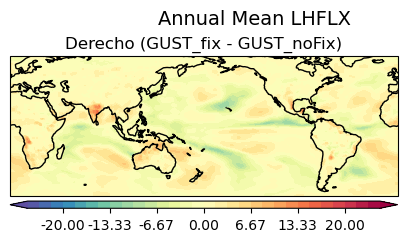

In [11]:
varSel = 'LHFLX'
diffMax = 25
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

# ---- shouldn't need to change much below here ----- 
fig,axs = plt.subplots(1,1,figsize=(5,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

plt.gcf().text(0.42, 0.75, 'Annual Mean '+varSel, fontsize=14)

axs.set_title('Derecho (GUST_fix - GUST_noFix)')
axs.coastlines()
axs.set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
cplt = axs.contourf(diff_drch_h0.lon.values, diff_drch_h0.lat.values, 
                    h0_drchFix.isel(case=1)[varSel].mean(dim='time').values -  h0_drchNoFix.isel(case=1)[varSel].mean(dim='time').values, 
                dLims, cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree())
# Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.018])
cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')


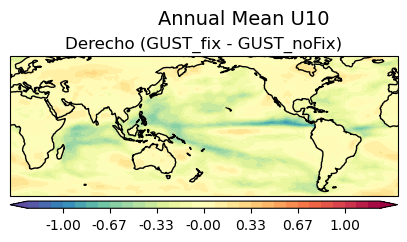

In [12]:
varSel = 'U10'
diffMax = 1.25
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

# ---- shouldn't need to change much below here ----- 
fig,axs = plt.subplots(1,1,figsize=(5,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

plt.gcf().text(0.42, 0.75, 'Annual Mean '+varSel, fontsize=14)

axs.set_title('Derecho (GUST_fix - GUST_noFix)')
axs.coastlines()
axs.set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
cplt = axs.contourf(diff_drch_h0.lon.values, diff_drch_h0.lat.values, 
                    h0_drchFix.isel(case=1)[varSel].mean(dim='time').values -  h0_drchNoFix.isel(case=1)[varSel].mean(dim='time').values, 
                dLims, cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree())
# Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.018])
cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')


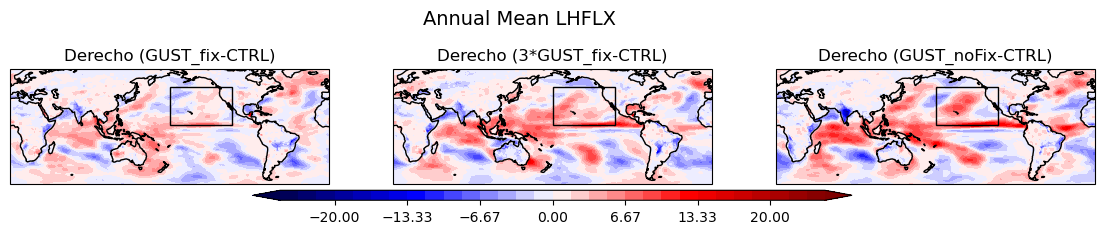

In [13]:
varSel = 'LHFLX'
diffMax = 25
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_AnnMean(varSel,dLims)

## Tropical NE Pacific
for iAxs in range(3): 
    axs[iAxs].add_patch(patches.Rectangle(xy=[180, 7], width=70, height=42,
                            facecolor='none', edgecolor='k',
                            linewidth=1, transform=ccrs.PlateCarree()))




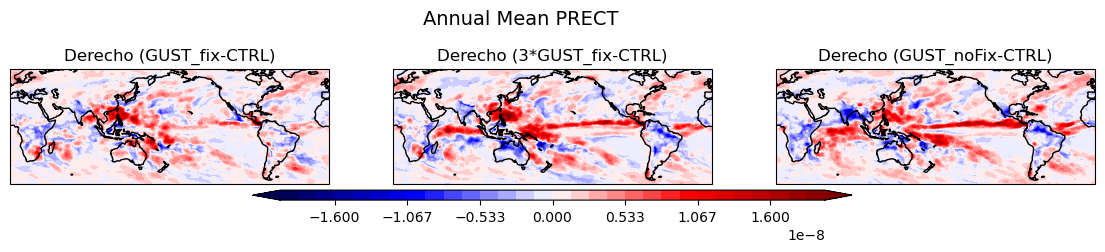

In [14]:
varSel = 'PRECT'
diffMax = 2e-8
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_AnnMean(varSel,dLims)


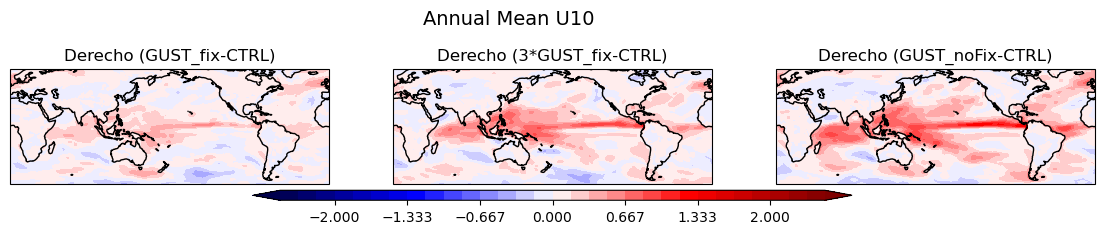

In [15]:
varSel = 'U10'
diffMax = 2.5
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_AnnMean(varSel,dLims)



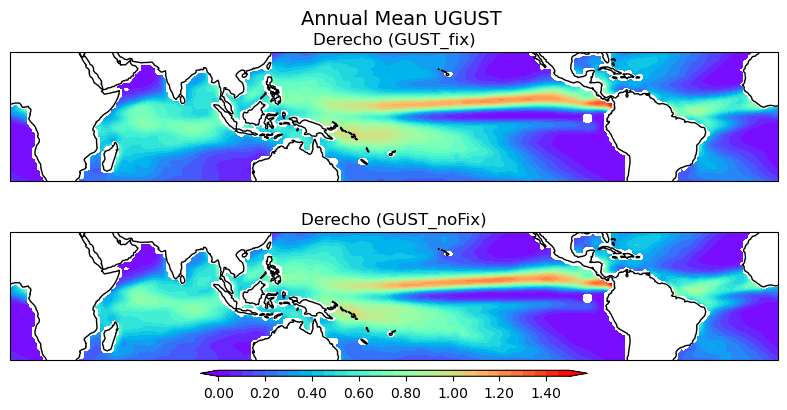

In [119]:
varSel = 'UGUST'
diffMax = 1.5
diffStep = (diffMax-0)/30
# dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)
dLims = np.arange(0, diffMax+diffStep, diffStep)

fig,axs = plt.subplots(2,1,figsize=(10,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

plt.gcf().text(0.42, 0.95, 'Annual Mean '+varSel, fontsize=14)

axs[0].set_title('Derecho (GUST_fix)')
axs[0].coastlines()
axs[0].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
cplt = axs[0].contourf(diff_drch_h0.lon.values, diff_drch_h0.lat.values, 
                       diff_drch_h0[varSel].mean(dim='time').values*fillOcnFrac_h0_mean, 
                dLims, cmap='rainbow',extend='both',transform=ccrs.PlateCarree())
# # Add colorbar
# ax_position = axs[0].get_position()
# cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.015])
# cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
# # cbar.set_label('m/s',fontsize=11)


axs[1].set_title('Derecho (GUST_noFix)')
axs[1].coastlines()
axs[1].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
cplt = axs[1].contourf(diff_drchNoFix_h0.lon.values, diff_drchNoFix_h0.lat.values, 
                       diff_drchNoFix_h0[varSel].mean(dim='time').values*fillOcnFrac_h0_mean, 
                dLims, cmap='rainbow',extend='both',transform=ccrs.PlateCarree())
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
# cbar.set_label('m/s',fontsize=11)

axs[0].set_extent([0,359,-30,30], crs=ccrs.PlateCarree())
axs[1].set_extent([0,359,-30,30], crs=ccrs.PlateCarree())

fig.subplots_adjust(hspace=0.4)

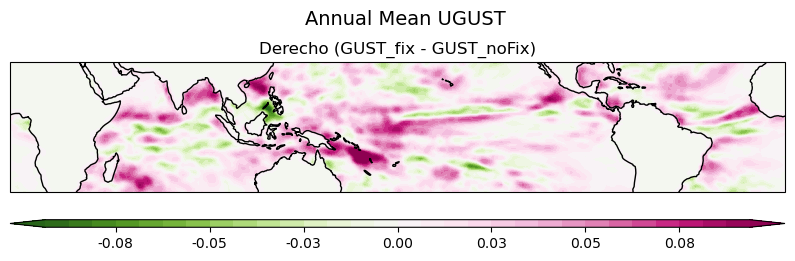

In [125]:
## Wht's the difference in UGUST between cases? 
varSel = 'UGUST'
diffMax = 0.1
diffStep = (diffMax*2)/30
# dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

fig,axs = plt.subplots(1,1,figsize=(10,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

plt.gcf().text(0.42, 0.75, 'Annual Mean '+varSel, fontsize=14)

axs.set_title('Derecho (GUST_fix - GUST_noFix)')
axs.coastlines()
axs.set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
cplt = axs.contourf(diff_drch_h0.lon.values, diff_drch_h0.lat.values, 
                      (h0_drchFix.isel(case=1)[varSel].mean(dim='time')-h0_drchNoFix.isel(case=1)[varSel].mean(dim='time')).values, 
                dLims, cmap='PiYG_r',extend='both',transform=ccrs.PlateCarree())
# Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0+0.1, ax_position.width, 0.019])
cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
# cbar.set_label('m/s',fontsize=11)


axs.set_extent([0,359,-30,30], crs=ccrs.PlateCarree())


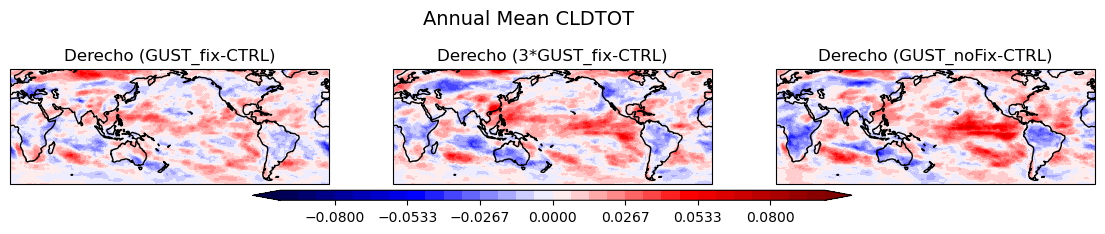

In [16]:
varSel = 'CLDTOT'
diffMax = 0.1
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_AnnMean(varSel,dLims)


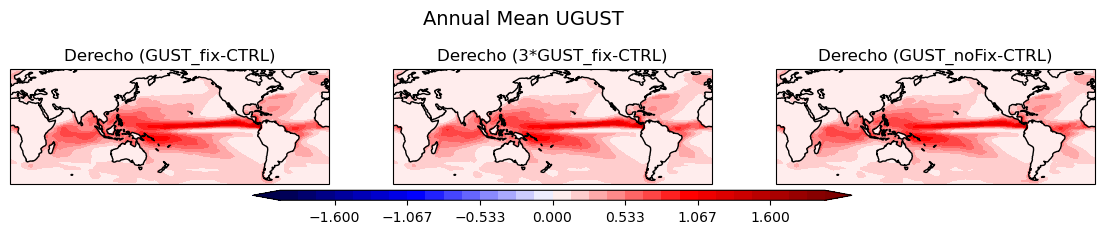

In [16]:
varSel = 'UGUST'
diffMax = 2
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_AnnMean(varSel,dLims)


### Check a season

In [17]:
## DJF 

diff_drchNoFix_h0_DJF = diff_drchNoFix_h0.isel(time=((diff_drchNoFix_h0.time.dt.month==12) | 
                                                    (diff_drchNoFix_h0.time.dt.month<=2)))

diff_drch_h0_DJF = diff_drch_h0.isel(time=((diff_drch_h0.time.dt.month==12) | 
                                                 (diff_drch_h0.time.dt.month<=2)))


diff_drch_x3_h0_DJF = diff_x3_drch_h0.isel(time=((diff_x3_drch_h0.time.dt.month==12) | 
                                                 (diff_x3_drch_h0.time.dt.month<=2)))


In [18]:
def pltComparison_DJFmean(varSel,dLims):    
    fig,axs = plt.subplots(1,3,figsize=(14,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    axs     = axs.ravel()
    
    plt.gcf().text(0.42, 0.75, 'DJF Mean '+varSel, fontsize=14)
    
    axs[0].set_title('Derecho (GUST_fix-CTRL)')
    axs[0].coastlines()
    axs[0].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
    cplt = axs[0].contourf(diff_drch_h0_DJF.lon.values, diff_drch_h0_DJF.lat.values, diff_drch_h0_DJF[varSel].mean(dim='time').values, 
                    dLims, cmap='seismic',extend='both',transform=ccrs.PlateCarree())
    # # Add colorbar
    # ax_position = axs[0].get_position()
    # cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
    # cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')

    ### Plot x3 case 
    axs[1].set_title('Derecho (3*GUST_fix-CTRL)')
    axs[1].coastlines()
    axs[1].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
    cplt = axs[1].contourf(diff_drch_x3_h0_DJF.lon.values, diff_drch_x3_h0_DJF.lat.values, diff_drch_x3_h0_DJF[varSel].mean(dim='time').values, 
                    dLims, cmap='seismic',extend='both',transform=ccrs.PlateCarree())
    # Add colorbar
    ax_position = axs[1].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.04, ax_position.width+0.2, 0.025])
    cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
    

    ### Plot noFix case
    axs[2].set_title('Derecho (GUST_noFix-CTRL)')
    axs[2].coastlines()
    axs[2].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
    cplt = axs[2].contourf(diff_drchNoFix_h0_DJF.lon.values, diff_drchNoFix_h0_DJF.lat.values, diff_drchNoFix_h0_DJF[varSel].mean(dim='time').values, 
                    dLims, cmap='seismic',extend='both',transform=ccrs.PlateCarree())
    # # Add colorbar
    # ax_position = axs[1].get_position()
    # cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
    # cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
    # cbar.set_label('m/s',fontsize=11)
    
    return axs


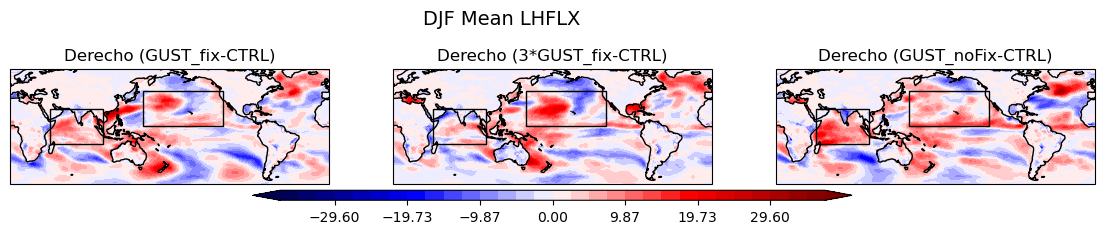

In [40]:
varSel = 'LHFLX'
diffMax = 37
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_DJFmean(varSel,dLims)


## Tropical NW Pacific/South China Sea
axs[0].add_patch(patches.Rectangle(xy=[45, -15], width=60, height=40,
                                    facecolor='none', edgecolor='k',
                                    linewidth=1,
                                    transform=ccrs.PlateCarree()))

axs[1].add_patch(patches.Rectangle(xy=[45, -15], width=60, height=40,
                                    facecolor='none', edgecolor='k',
                                    linewidth=1,
                                    transform=ccrs.PlateCarree()))

axs[2].add_patch(patches.Rectangle(xy=[45, -15], width=60, height=40,
                                    facecolor='none', edgecolor='k',
                                    linewidth=1,
                                    transform=ccrs.PlateCarree()))

## Tropical NE Pacific
axs[0].add_patch(patches.Rectangle(xy=[150, 5], width=90, height=40,
                                    facecolor='none', edgecolor='k',
                                    linewidth=1,
                                    transform=ccrs.PlateCarree()))

axs[1].add_patch(patches.Rectangle(xy=[150, 5], width=90, height=40,
                                    facecolor='none', edgecolor='k',
                                    linewidth=1,
                                    transform=ccrs.PlateCarree()))

axs[2].add_patch(patches.Rectangle(xy=[150, 5], width=90, height=40,
                                    facecolor='none', edgecolor='k',
                                    linewidth=1,
                                    transform=ccrs.PlateCarree()))


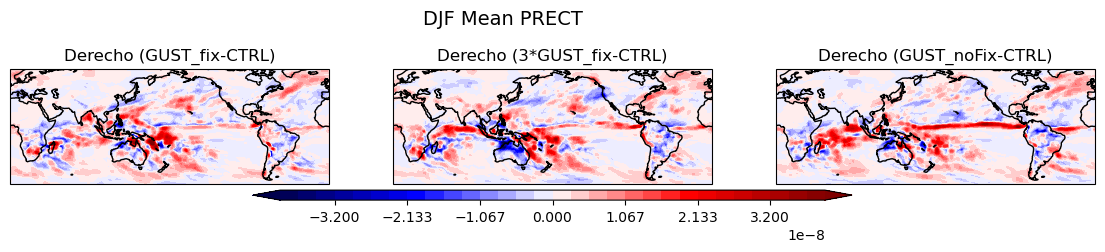

In [20]:
varSel = 'PRECT'
diffMax = 4e-8
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_DJFmean(varSel,dLims)


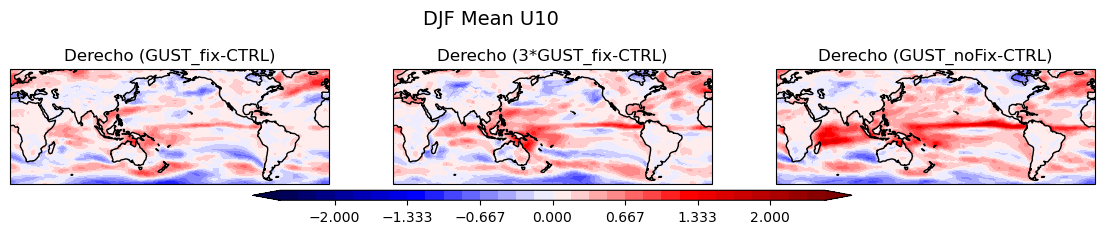

In [21]:
varSel = 'U10'
diffMax = 2.5
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_DJFmean(varSel,dLims)


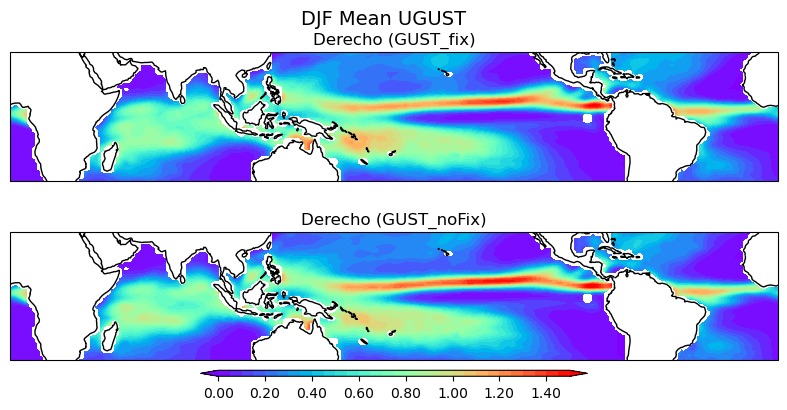

In [22]:
varSel = 'UGUST'
diffMax = 1.5
diffStep = (diffMax-0)/30
# dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)
dLims = np.arange(0, diffMax+diffStep, diffStep)

fig,axs = plt.subplots(2,1,figsize=(10,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

plt.gcf().text(0.42, 0.95, 'DJF Mean '+varSel, fontsize=14)

axs[0].set_title('Derecho (GUST_fix)')
axs[0].coastlines()
axs[0].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
cplt = axs[0].contourf(diff_drch_h0_DJF.lon.values, diff_drch_h0_DJF.lat.values, 
                       diff_drch_h0_DJF[varSel].mean(dim='time').values*fillOcnFrac_h0_mean, 
                dLims, cmap='rainbow',extend='both',transform=ccrs.PlateCarree())
# # Add colorbar
# ax_position = axs[0].get_position()
# cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.015])
# cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
# # cbar.set_label('m/s',fontsize=11)


axs[1].set_title('Derecho (GUST_noFix)')
axs[1].coastlines()
axs[1].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
cplt = axs[1].contourf(diff_drchNoFix_h0_DJF.lon.values, diff_drchNoFix_h0_DJF.lat.values, 
                       diff_drchNoFix_h0_DJF[varSel].mean(dim='time').values*fillOcnFrac_h0_mean, 
                dLims, cmap='rainbow',extend='both',transform=ccrs.PlateCarree())
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
# cbar.set_label('m/s',fontsize=11)

axs[0].set_extent([0,359,-30,30], crs=ccrs.PlateCarree())
axs[1].set_extent([0,359,-30,30], crs=ccrs.PlateCarree())

fig.subplots_adjust(hspace=0.4)

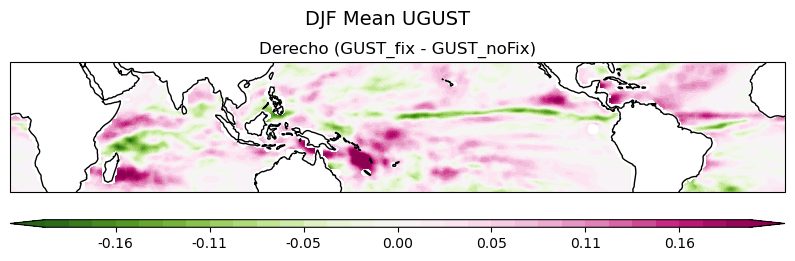

In [131]:
## Wht's the difference in UGUST between cases? 
varSel = 'UGUST'
diffMax = 0.2
diffStep = (diffMax*2)/30
# dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

fig,axs = plt.subplots(1,1,figsize=(10,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

plt.gcf().text(0.42, 0.75, 'DJF Mean '+varSel, fontsize=14)

diffVar = (diff_drch_h0_DJF[varSel].mean(dim='time').values*fillOcnFrac_h0_mean) - (diff_drchNoFix_h0_DJF[varSel].mean(dim='time').values*fillOcnFrac_h0_mean)

axs.set_title('Derecho (GUST_fix - GUST_noFix)')
axs.coastlines()
axs.set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
cplt = axs.contourf(diff_drch_h0.lon.values, diff_drch_h0.lat.values, diffVar, 
                dLims, cmap='PiYG_r',extend='both',transform=ccrs.PlateCarree())
# Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0+0.1, ax_position.width, 0.019])
cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
# cbar.set_label('m/s',fontsize=11)


axs.set_extent([0,359,-30,30], crs=ccrs.PlateCarree())


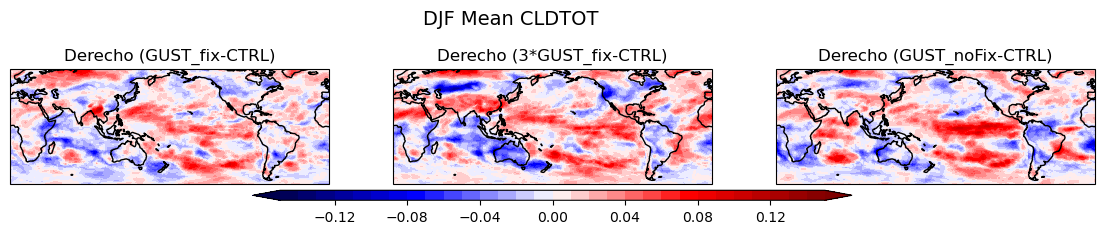

In [23]:
varSel = 'CLDTOT'
diffMax = 0.15
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_DJFmean(varSel,dLims)


'kg/m2'

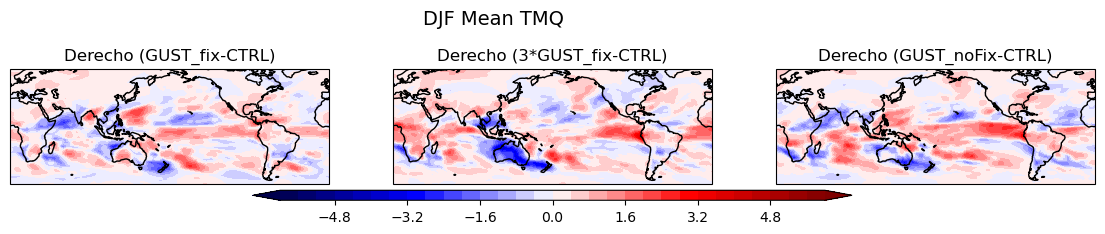

In [24]:
varSel = 'TMQ'
diffMax = 6
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_DJFmean(varSel,dLims)

h0_drchFix.TMQ.units

In [28]:
diff_drch_h0_DJF['OMEGA_500']      = (('time','lat','lon'), diff_drch_h0_DJF.OMEGA.sel(lev=500,method='nearest').values)
diff_drch_x3_h0_DJF['OMEGA_500']      = (('time','lat','lon'), diff_drch_x3_h0_DJF.OMEGA.sel(lev=500,method='nearest').values)
diff_drchNoFix_h0_DJF['OMEGA_500'] = (('time','lat','lon'), diff_drchNoFix_h0_DJF.OMEGA.sel(lev=500,method='nearest').values)


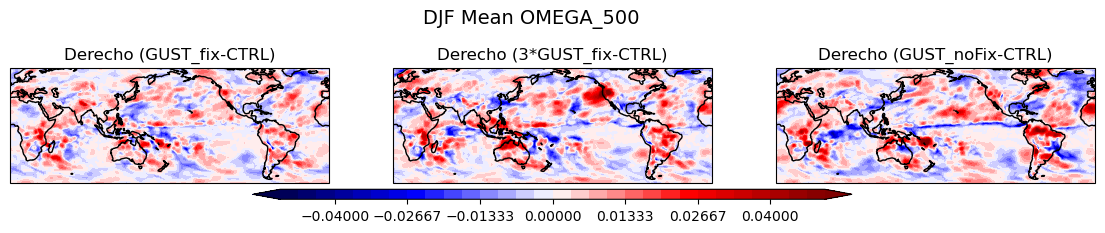

In [29]:
varSel = 'OMEGA_500'
diffMax = 0.05
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_DJFmean(varSel,dLims)


**JJA**

In [31]:
## JJA 

diff_drchNoFix_h0_JJA = diff_drchNoFix_h0.isel(time=((diff_drchNoFix_h0.time.dt.month>=6) | 
                                                    (diff_drchNoFix_h0.time.dt.month<=8)))

diff_drch_h0_JJA = diff_drch_h0.isel(time=((diff_drch_h0.time.dt.month>=6) | 
                                                 (diff_drch_h0.time.dt.month<=8)))


diff_drch_x3_h0_JJA = diff_x3_drch_h0.isel(time=((diff_x3_drch_h0.time.dt.month>=6) | 
                                                 (diff_x3_drch_h0.time.dt.month<=8)))


In [32]:
def pltComparison_JJAmean(varSel,dLims):    
    fig,axs = plt.subplots(1,3,figsize=(14,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    axs     = axs.ravel()
    
    plt.gcf().text(0.42, 0.75, 'JJA Mean '+varSel, fontsize=14)
    
    axs[0].set_title('Derecho (GUST_fix-CTRL)')
    axs[0].coastlines()
    axs[0].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
    cplt = axs[0].contourf(diff_drch_h0_JJA.lon.values, diff_drch_h0_JJA.lat.values, diff_drch_h0_JJA[varSel].mean(dim='time').values, 
                    dLims, cmap='seismic',extend='both',transform=ccrs.PlateCarree())
    # # Add colorbar
    # ax_position = axs[0].get_position()
    # cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
    # cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')

    ### Plot x3 case 
    axs[1].set_title('Derecho (3*GUST_fix-CTRL)')
    axs[1].coastlines()
    axs[1].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
    cplt = axs[1].contourf(diff_drch_x3_h0_JJA.lon.values, diff_drch_x3_h0_JJA.lat.values, diff_drch_x3_h0_JJA[varSel].mean(dim='time').values, 
                    dLims, cmap='seismic',extend='both',transform=ccrs.PlateCarree())
    # Add colorbar
    ax_position = axs[1].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.04, ax_position.width+0.2, 0.025])
    cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
    

    ### Plot noFix case
    axs[2].set_title('Derecho (GUST_noFix-CTRL)')
    axs[2].coastlines()
    axs[2].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
    cplt = axs[2].contourf(diff_drchNoFix_h0_JJA.lon.values, diff_drchNoFix_h0_JJA.lat.values, diff_drchNoFix_h0_JJA[varSel].mean(dim='time').values, 
                    dLims, cmap='seismic',extend='both',transform=ccrs.PlateCarree())
    # # Add colorbar
    # ax_position = axs[1].get_position()
    # cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
    # cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
    # cbar.set_label('m/s',fontsize=11)
    
    return axs


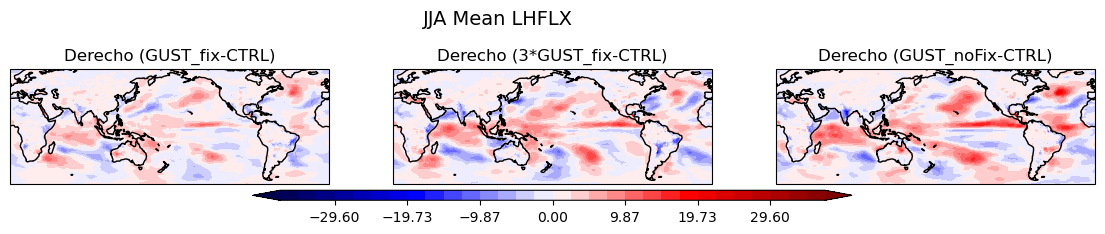

In [33]:
varSel = 'LHFLX'
diffMax = 37
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_JJAmean(varSel,dLims)


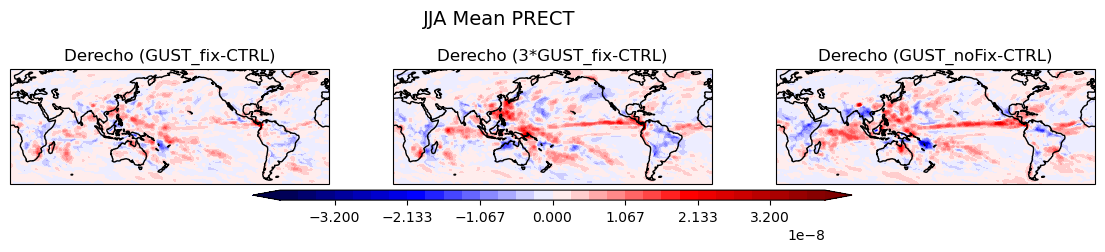

In [34]:
varSel = 'PRECT'
diffMax = 4e-8
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_JJAmean(varSel,dLims)


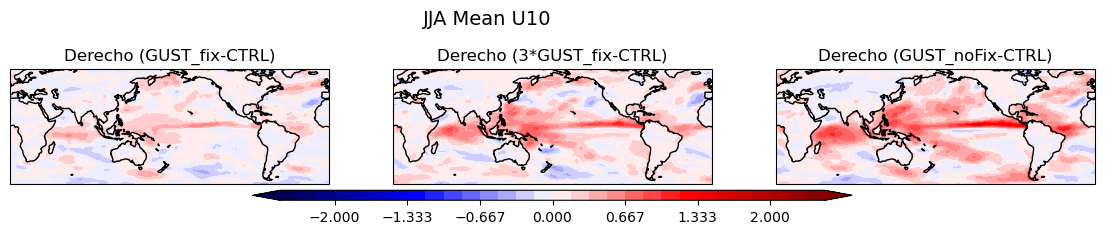

In [35]:
varSel = 'U10'
diffMax = 2.5
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_JJAmean(varSel,dLims)


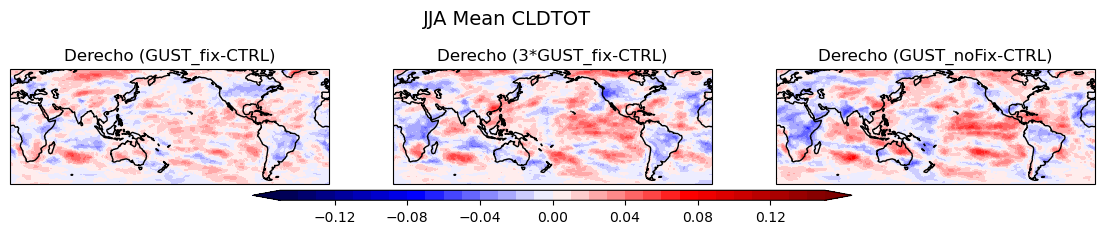

In [36]:
varSel = 'CLDTOT'
diffMax = 0.15
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_JJAmean(varSel,dLims)


'kg/m2'

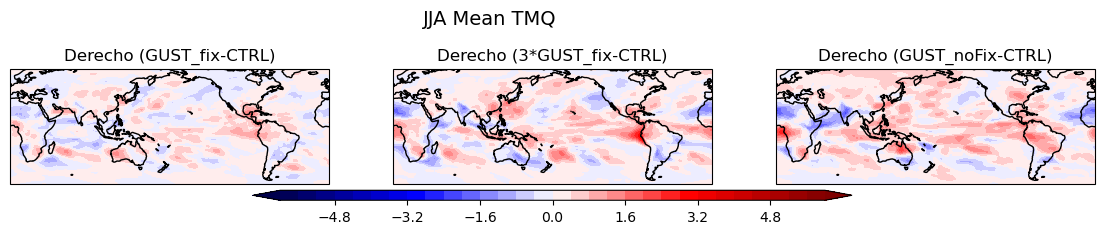

In [37]:
varSel = 'TMQ'
diffMax = 6
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_JJAmean(varSel,dLims)

h0_drchFix.TMQ.units

## Biases?

### Read in the obs

Note: /glade/p/ was removed. I'm not sure if the obs_data for amwg_diagnostics was ever moved somewhere, but a quick poke around /glade/campaign hasn't revealed it yet...

In [25]:
## Get daily TRMM data that's not regridded just yet 
dataDir = '/glade/campaign/cgd/amp/rneale/data/TRMM/daily/0.25deg/'

# Get list of files 
listFiles_trmm = np.sort(glob.glob(dataDir+'3B42.????.daily_V7.nc'))
## Now read in those files
trmmDS = xr.open_mfdataset(listFiles_trmm, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')



In [26]:
## Read in ERA-5 Monthly means for the same period 
filePath = '/glade/work/mdfowler/obs/ERA5_monthlyAvg_1995to2014_fluxesAndRain.nc'
era5_obs = xr.open_dataset(filePath, decode_times=True)

## Add neutral 10m wind components 
fileNeut = '/glade/work/mdfowler/obs/ERA5_monthlyAvg_1995to2014_neutral10mWinds.nc'
era5_neut = xr.open_dataset(fileNeut, decode_times=True)
era5_obs = xr.merge([era5_obs, era5_neut])

era5_obs = era5_obs.reindex(latitude=era5_obs.latitude[::-1])
era5_obs = era5_obs.rename_dims(dims_dict={'latitude':'lat', 'longitude':'lon'})
era5_obs = era5_obs.rename(name_dict={'latitude':'lat', 'longitude':'lon'})

# Now regrid the data
# Get model grid 
camGrid = h0_drchFix['LHFLX'].isel(time=0,case=0).load().squeeze()

# lhflx_era5 = era5_obs['slhf'].where(era5_obs['slhf'].values>-999)
lhflx_era5 = -era5_obs['slhf']/86400  # Divide fluxes by 86400 to get from J/m2 to W/m2; Add negative sign to match CAM convention 
regridERA5_lhflx = regrid_data(lhflx_era5, camGrid, method=1)

## NOW: use neutral winds for 10m u and v 
era5_u10_temp = era5_obs['u10n']
era5_v10_temp = era5_obs['v10n']
u10_era5 = np.sqrt(era5_u10_temp**2 + era5_v10_temp**2)
regridERA5_u10 = regrid_data(u10_era5, camGrid, method=1)

era5_prect_temp  = era5_obs['tp']
era5_prect_temp  =  era5_prect_temp * 1000.0  # Convert from m of water per day to mm/day
regridERA5_prect = regrid_data(era5_prect_temp, camGrid, method=1)

## Combine back into one xarray dataset
regridERA5 = regridERA5_lhflx.to_dataset()
regridERA5['U10'] = (('time','lat','lon'), regridERA5_u10.values)
regridERA5['tp'] = (('time','lat','lon'), regridERA5_prect.values)
# regridERA5 = xr.merge([regridERA5_lhflx, regridERA5_u10, regridERA5_prect])

## Select certain seasons and average over those 
iTimes_DJF = np.where( (regridERA5['time.month']==12) | (regridERA5['time.month']<=2) )[0]
iTimes_JJA = np.where( (regridERA5['time.month']>=6) &  (regridERA5['time.month']<=8) )[0]
iTimes_MAM = np.where( (regridERA5['time.month']>=3) &  (regridERA5['time.month']<=5) )[0]
iTimes_SON = np.where( (regridERA5['time.month']>=9) &  (regridERA5['time.month']<=11) )[0]

regridERA5_DJF = regridERA5.isel(time=iTimes_DJF).mean(dim='time')
regridERA5_JJA = regridERA5.isel(time=iTimes_JJA).mean(dim='time')
regridERA5_MAM = regridERA5.isel(time=iTimes_MAM).mean(dim='time')
regridERA5_SON = regridERA5.isel(time=iTimes_SON).mean(dim='time')
regridERA5_ANN = regridERA5.mean(dim='time')

era5_DJF_allTimes = regridERA5.isel(time=iTimes_DJF)


In [12]:
## Read in daily ERA5 PRECT too?
fileName = '/glade/work/rneale/data/ERA5/PRECT.day.mean.leap.nc'
era5_daily = xr.open_dataset(fileName, decode_times=True)

## Select same set of years 
iYears = np.where((era5_daily['time.year']>=1996) & (era5_daily['time.year']<=2014))[0]

era5_prect_temp  =  era5_daily['tp'].isel(time=iYears)
era5_prect_temp  =  era5_prect_temp * 1000.0 # Convert from m of water per day to mm/day
regridERA5_prectDaily =  regrid_data(era5_prect_temp, camGrid, method=1)



In [15]:
# ## Also read in the 3D ERA5 OMEGA field 
# filePath = '/glade/work/mdfowler/obs/ERA5_omega.nc'
# era5_omega = xr.open_dataset(filePath, decode_times=True)

# era5_omega = era5_omega.reindex(latitude=era5_omega.latitude[::-1])
# era5_omega = era5_omega.rename_dims(dims_dict={'latitude':'lat', 'longitude':'lon'})
# era5_omega = era5_omega.rename(name_dict={'latitude':'lat', 'longitude':'lon'})

# ## Convert longitude to be 0 to 360, not -180 to 180 (not an issue above that I can tell)
# era5_omega.coords['lon'] = (era5_omega.coords['lon'] + 360) % 360 
# era5_omega = era5_omega.sortby(era5_omega.lon)

# regridERA5_omega = regrid_data(era5_omega, camGrid, method=1)

# iTimes_DJF = np.where( (regridERA5_omega['time.month']==12) | (regridERA5_omega['time.month']<=2) )[0]
# regridERA5_omega_DJF = regridERA5_omega.isel(time=iTimes_DJF).mean(dim='time')

# regridERA5_DJF['OMEGA500'] = (('lat','lon'), np.squeeze(regridERA5_omega_DJF.sel(level=500).w.values))

### Make some bias plots

In [27]:
## Get annual mean in each case
ctrl_h0  = h0_drchFix.isel(case=0).mean(dim='time')
fix_h0   = h0_drchFix.isel(case=1).mean(dim='time')
x3fix_h0 = h0_drchFix.isel(case=2).mean(dim='time')
noFix_h0 =h0_drchNoFix.isel(case=1).mean(dim='time') 



In [28]:
## Get seasonal mean in each case
iTimes_DJF  = np.where( (h0_drchFix['time.month']==12) | (h0_drchFix['time.month']<=2) )[0]
iTimes2_DJF = np.where( (h0_drchNoFix['time.month']==12) | (h0_drchNoFix['time.month']<=2) )[0]

ctrl_h0_djf  = h0_drchFix.isel(case=0,   time=iTimes_DJF).mean(dim='time')
fix_h0_djf   = h0_drchFix.isel(case=1,   time=iTimes_DJF).mean(dim='time')
x3fix_h0_djf = h0_drchFix.isel(case=2,   time=iTimes_DJF).mean(dim='time')
noFix_h0_djf = h0_drchNoFix.isel(case=1, time=iTimes2_DJF).mean(dim='time') 



In [41]:
h0_drchFix.isel(case=0,   time=iTimes_DJF).time.values[-1]

cftime.DatetimeNoLeap(9, 12, 16, 12, 0, 0, 0, has_year_zero=True)

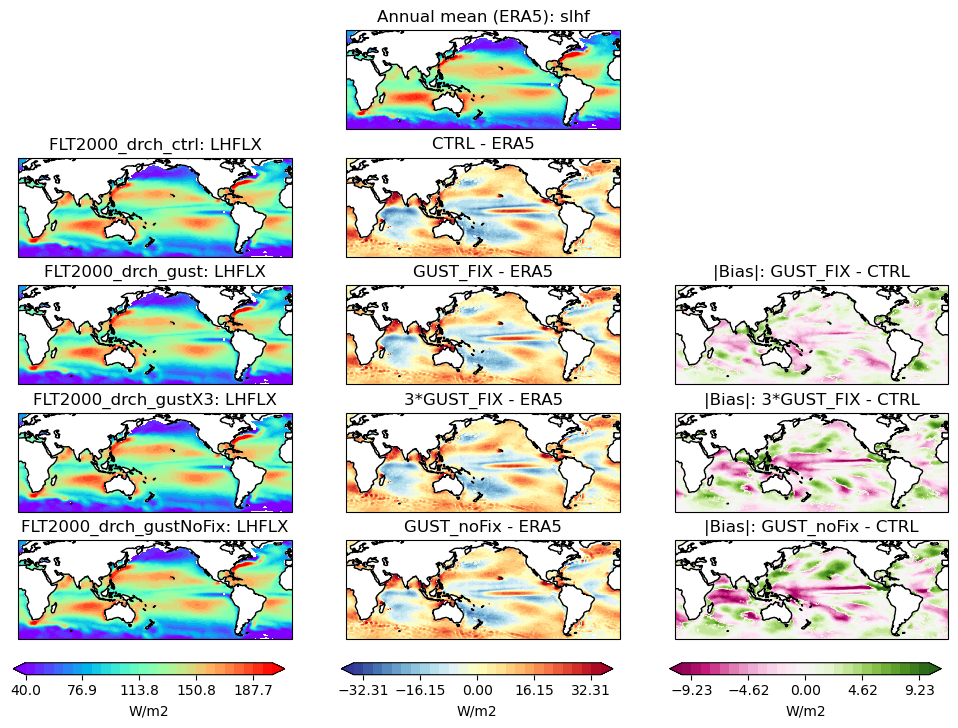

In [29]:
obsDS   = regridERA5_ANN
obsVar  = 'slhf'
obsMult = 1 

camVar  = 'LHFLX' 
camMult = 1

lStep       = (200-40)/26
levsMap     = np.arange(40,200+lStep, lStep)
dMax        = 35 
dStep       = (2*dMax)/26
diffLevs    = np.arange(-dMax,dMax+dStep,dStep)
biasMax     = 10 
bStep       = (2*biasMax)/26
biasLevs    = np.arange(-biasMax,biasMax+bStep,bStep)
unitsString = h0_drchFix['LHFLX'].units

cmap_sel = 'rainbow'

fig,axs = plt.subplots(5,3, figsize = (12,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

## Plot obs 
## - - - - - - - - - - 
axs[1].contourf(obsDS.lon.values, obsDS.lat.values, obsMult*obsDS[obsVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[1].set_title('Annual mean (ERA5): '+obsVar)

## Plot raw values 
## - - - - - - - - - - 
cmap_sel = 'rainbow'
axs[3].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, camMult*ctrl_h0[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[3].set_title(str(ctrl_h0.case.values)+': '+camVar)

axs[6].contourf(fix_h0.lon.values, fix_h0.lat.values, camMult*fix_h0[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[6].set_title(str(fix_h0.case.values)+': '+camVar)

axs[9].contourf(x3fix_h0.lon.values, x3fix_h0.lat.values, camMult*x3fix_h0[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[9].set_title(str(x3fix_h0.case.values)+': '+camVar)

c = axs[12].contourf(noFix_h0.lon.values, noFix_h0.lat.values, camMult*noFix_h0[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[12].set_title(str(noFix_h0.case.values)+': '+camVar)
# Add colorbar
ax_position = axs[12].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.04, ax_position.width+0.05, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax, label=unitsString)
cbar.ax.locator_params(nbins=5)


## Plot bias 
## - - - - - - - - - - 
bias_ctrl  = (camMult*ctrl_h0[camVar].values) - (obsMult*obsDS[obsVar].values) 
bias_fix   = (camMult*fix_h0[camVar].values) - (obsMult*obsDS[obsVar].values) 
bias_fix3  = (camMult*x3fix_h0[camVar].values) - (obsMult*obsDS[obsVar].values) 
bias_nofix = (camMult*noFix_h0[camVar].values) - (obsMult*obsDS[obsVar].values) 

axs[4].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_ctrl*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[4].set_title('CTRL - ERA5')

axs[7].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_fix*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[7].set_title('GUST_FIX - ERA5')

axs[10].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_fix3*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[10].set_title('3*GUST_FIX - ERA5')

c = axs[13].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_nofix*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[13].set_title('GUST_noFix - ERA5')
# Add colorbar
ax_position = axs[13].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.04, ax_position.width+0.05, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax, label=unitsString)
cbar.ax.locator_params(nbins=5)


## Plot diff in abs value of bias 
## - - - - - - - - - - 
axs[8].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, np.abs(bias_fix*fillOcnFrac_h0_mean) - np.abs(bias_ctrl*fillOcnFrac_h0_mean),
                biasLevs, cmap='PiYG', extend='both',transform=ccrs.PlateCarree())
axs[8].set_title('|Bias|: GUST_FIX - CTRL')

axs[11].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, np.abs(bias_fix3*fillOcnFrac_h0_mean) - np.abs(bias_ctrl*fillOcnFrac_h0_mean),
                biasLevs, cmap='PiYG', extend='both',transform=ccrs.PlateCarree())
axs[11].set_title('|Bias|: 3*GUST_FIX - CTRL')

c=axs[14].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, np.abs(bias_nofix*fillOcnFrac_h0_mean) - np.abs(bias_ctrl*fillOcnFrac_h0_mean),
                biasLevs, cmap='PiYG', extend='both',transform=ccrs.PlateCarree())
axs[14].set_title('|Bias|: GUST_noFix - CTRL')
# Add colorbar
ax_position = axs[14].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.04, ax_position.width+0.05, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax, label=unitsString)
cbar.ax.locator_params(nbins=5)


## Limits on plots and other options 
## - - - - - - - - - - 

for iAxs in range(len(axs)):
    axs[iAxs].coastlines()
    axs[iAxs].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())

fig.delaxes(axs[0])
fig.delaxes(axs[2])
fig.delaxes(axs[5])


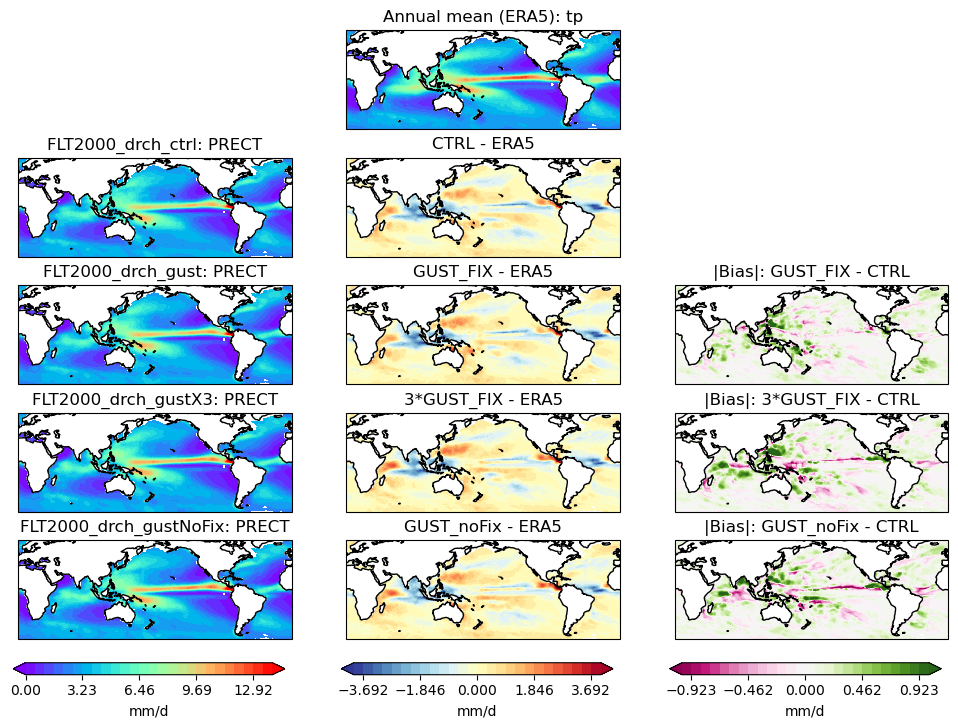

In [30]:
obsDS   = regridERA5_ANN
obsVar  = 'tp'
obsMult = 1 

camVar  = 'PRECT' 
camMult = 86400*(1e3)

lStep       = (14-0)/26
levsMap     = np.arange(0,14+lStep, lStep)
dMax        = 4
dStep       = (2*dMax)/26
diffLevs    = np.arange(-dMax,dMax+dStep,dStep)
biasMax     = 1
bStep       = (2*biasMax)/26
biasLevs    = np.arange(-biasMax,biasMax+bStep,bStep)
unitsString = 'mm/d'

cmap_sel = 'rainbow'

fig,axs = plt.subplots(5,3, figsize = (12,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

## Plot obs 
## - - - - - - - - - - 
axs[1].contourf(obsDS.lon.values, obsDS.lat.values, obsMult*obsDS[obsVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[1].set_title('Annual mean (ERA5): '+obsVar)

## Plot raw values 
## - - - - - - - - - - 
cmap_sel = 'rainbow'
axs[3].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, camMult*ctrl_h0[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[3].set_title(str(ctrl_h0.case.values)+': '+camVar)

axs[6].contourf(fix_h0.lon.values, fix_h0.lat.values, camMult*fix_h0[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[6].set_title(str(fix_h0.case.values)+': '+camVar)

axs[9].contourf(x3fix_h0.lon.values, x3fix_h0.lat.values, camMult*x3fix_h0[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[9].set_title(str(x3fix_h0.case.values)+': '+camVar)

c = axs[12].contourf(noFix_h0.lon.values, noFix_h0.lat.values, camMult*noFix_h0[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[12].set_title(str(noFix_h0.case.values)+': '+camVar)
# Add colorbar
ax_position = axs[12].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.04, ax_position.width+0.05, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax, label=unitsString)
cbar.ax.locator_params(nbins=5)


## Plot bias 
## - - - - - - - - - - 
bias_ctrl  = (camMult*ctrl_h0[camVar].values) - (obsMult*obsDS[obsVar].values) 
bias_fix   = (camMult*fix_h0[camVar].values) - (obsMult*obsDS[obsVar].values) 
bias_fix3  = (camMult*x3fix_h0[camVar].values) - (obsMult*obsDS[obsVar].values) 
bias_nofix = (camMult*noFix_h0[camVar].values) - (obsMult*obsDS[obsVar].values) 

axs[4].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_ctrl*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[4].set_title('CTRL - ERA5')

axs[7].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_fix*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[7].set_title('GUST_FIX - ERA5')

axs[10].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_fix3*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[10].set_title('3*GUST_FIX - ERA5')

c = axs[13].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_nofix*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[13].set_title('GUST_noFix - ERA5')
# Add colorbar
ax_position = axs[13].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.04, ax_position.width+0.05, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax, label=unitsString)
cbar.ax.locator_params(nbins=5)


## Plot diff in abs value of bias 
## - - - - - - - - - - 
axs[8].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, np.abs(bias_fix*fillOcnFrac_h0_mean) - np.abs(bias_ctrl*fillOcnFrac_h0_mean),
                biasLevs, cmap='PiYG', extend='both',transform=ccrs.PlateCarree())
axs[8].set_title('|Bias|: GUST_FIX - CTRL')

axs[11].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, np.abs(bias_fix3*fillOcnFrac_h0_mean) - np.abs(bias_ctrl*fillOcnFrac_h0_mean),
                biasLevs, cmap='PiYG', extend='both',transform=ccrs.PlateCarree())
axs[11].set_title('|Bias|: 3*GUST_FIX - CTRL')

c=axs[14].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, np.abs(bias_nofix*fillOcnFrac_h0_mean) - np.abs(bias_ctrl*fillOcnFrac_h0_mean),
                biasLevs, cmap='PiYG', extend='both',transform=ccrs.PlateCarree())
axs[14].set_title('|Bias|: GUST_noFix - CTRL')
# Add colorbar
ax_position = axs[14].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.04, ax_position.width+0.05, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax, label=unitsString)
cbar.ax.locator_params(nbins=5)


## Limits on plots and other options 
## - - - - - - - - - - 

for iAxs in range(len(axs)):
    axs[iAxs].coastlines()
    axs[iAxs].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())

fig.delaxes(axs[0])
fig.delaxes(axs[2])
fig.delaxes(axs[5])


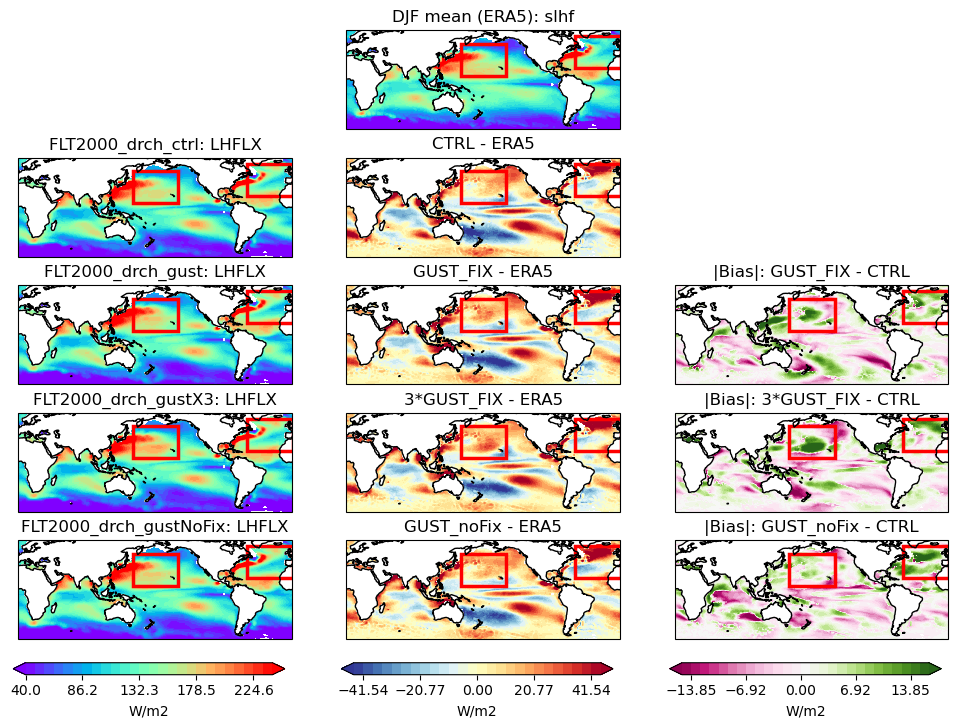

In [42]:
obsDS   = regridERA5_DJF
obsVar  = 'slhf'
obsMult = 1 

camVar  = 'LHFLX' 
camMult = 1

lStep       = (240-40)/26
levsMap     = np.arange(40,240+lStep, lStep)
dMax        = 45 
dStep       = (2*dMax)/26
diffLevs    = np.arange(-dMax,dMax+dStep,dStep)
biasMax     = 15 
bStep       = (2*biasMax)/26
biasLevs    = np.arange(-biasMax,biasMax+bStep,bStep)
unitsString = h0_drchFix['LHFLX'].units

cmap_sel = 'rainbow'

fig,axs = plt.subplots(5,3, figsize = (12,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

## Plot obs 
## - - - - - - - - - - 
axs[1].contourf(obsDS.lon.values, obsDS.lat.values, obsMult*obsDS[obsVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[1].set_title('DJF mean (ERA5): '+obsVar)

## Plot raw values 
## - - - - - - - - - - 
cmap_sel = 'rainbow'
axs[3].contourf(ctrl_h0_djf.lon.values, ctrl_h0_djf.lat.values, camMult*ctrl_h0_djf[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[3].set_title(str(ctrl_h0_djf.case.values)+': '+camVar)

axs[6].contourf(fix_h0_djf.lon.values, fix_h0_djf.lat.values, camMult*fix_h0_djf[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[6].set_title(str(fix_h0_djf.case.values)+': '+camVar)

axs[9].contourf(x3fix_h0_djf.lon.values, x3fix_h0_djf.lat.values, camMult*x3fix_h0_djf[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[9].set_title(str(x3fix_h0_djf.case.values)+': '+camVar)

c = axs[12].contourf(noFix_h0_djf.lon.values, noFix_h0_djf.lat.values, camMult*noFix_h0_djf[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[12].set_title(str(noFix_h0_djf.case.values)+': '+camVar)
# Add colorbar
ax_position = axs[12].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.04, ax_position.width+0.05, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax, label=unitsString)
cbar.ax.locator_params(nbins=5)


## Plot bias 
## - - - - - - - - - - 
bias_ctrl  = (camMult*ctrl_h0_djf[camVar].values) - (obsMult*obsDS[obsVar].values) 
bias_fix   = (camMult*fix_h0_djf[camVar].values) - (obsMult*obsDS[obsVar].values) 
bias_fix3  = (camMult*x3fix_h0_djf[camVar].values) - (obsMult*obsDS[obsVar].values) 
bias_nofix = (camMult*noFix_h0_djf[camVar].values) - (obsMult*obsDS[obsVar].values) 

axs[4].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_ctrl*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[4].set_title('CTRL - ERA5')

axs[7].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_fix*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[7].set_title('GUST_FIX - ERA5')

axs[10].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_fix3*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[10].set_title('3*GUST_FIX - ERA5')

c = axs[13].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_nofix*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[13].set_title('GUST_noFix - ERA5')
# Add colorbar
ax_position = axs[13].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.04, ax_position.width+0.05, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax, label=unitsString)
cbar.ax.locator_params(nbins=5)


## Plot diff in abs value of bias 
## - - - - - - - - - - 
axs[8].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, np.abs(bias_fix*fillOcnFrac_h0_mean) - np.abs(bias_ctrl*fillOcnFrac_h0_mean),
                biasLevs, cmap='PiYG', extend='both',transform=ccrs.PlateCarree())
axs[8].set_title('|Bias|: GUST_FIX - CTRL')

axs[11].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, np.abs(bias_fix3*fillOcnFrac_h0_mean) - np.abs(bias_ctrl*fillOcnFrac_h0_mean),
                biasLevs, cmap='PiYG', extend='both',transform=ccrs.PlateCarree())
axs[11].set_title('|Bias|: 3*GUST_FIX - CTRL')

c=axs[14].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, np.abs(bias_nofix*fillOcnFrac_h0_mean) - np.abs(bias_ctrl*fillOcnFrac_h0_mean),
                biasLevs, cmap='PiYG', extend='both',transform=ccrs.PlateCarree())
axs[14].set_title('|Bias|: GUST_noFix - CTRL')
# Add colorbar
ax_position = axs[14].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.04, ax_position.width+0.05, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax, label=unitsString)
cbar.ax.locator_params(nbins=5)


## Limits on plots and other options 
## - - - - - - - - - - 

for iAxs in range(len(axs)):
    axs[iAxs].coastlines()
    axs[iAxs].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())

fig.delaxes(axs[0])
fig.delaxes(axs[2])
fig.delaxes(axs[5])

## Add some rectangles!
for iAxs in range(len(axs)): 
    axs[iAxs].add_patch(patches.Rectangle(xy=[300, 20], width=60, height=42,
                            facecolor='none', edgecolor='r',
                            linewidth=2.5, transform=ccrs.PlateCarree()))
    
    axs[iAxs].add_patch(patches.Rectangle(xy=[150, 10], width=60, height=42,
                            facecolor='none', edgecolor='r',
                            linewidth=2.5, transform=ccrs.PlateCarree()))


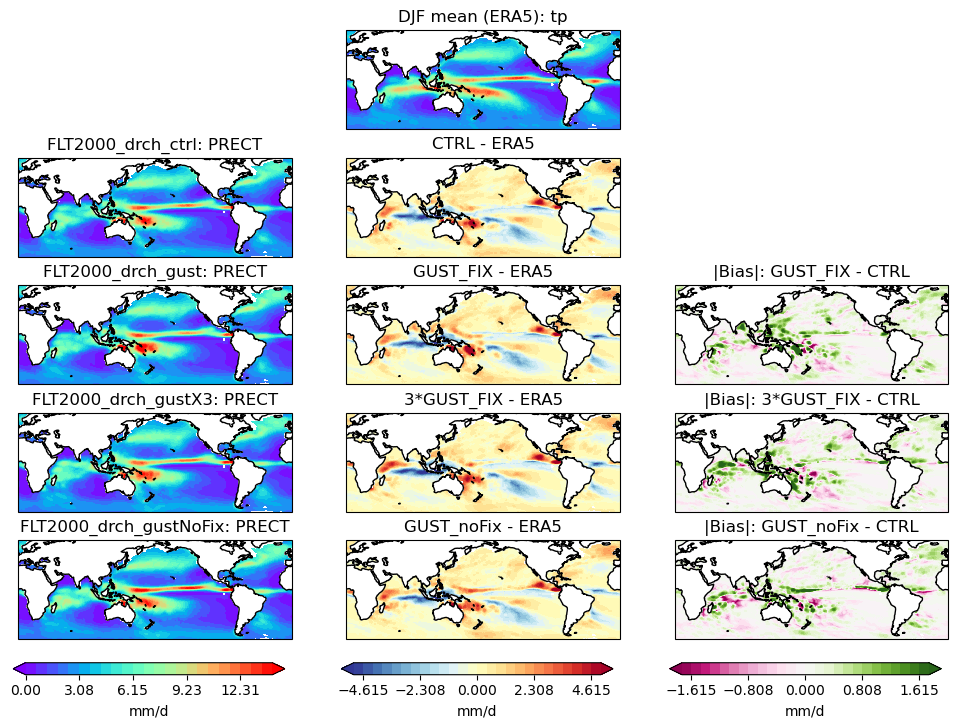

In [32]:
obsDS   = regridERA5_DJF
obsVar  = 'tp'
obsMult = 1 

camVar  = 'PRECT' 
camMult = 86400*(1e3)

lStep       = (16-0)/26
levsMap     = np.arange(0,14+lStep, lStep)
dMax        = 5
dStep       = (2*dMax)/26
diffLevs    = np.arange(-dMax,dMax+dStep,dStep)
biasMax     = 1.75
bStep       = (2*biasMax)/26
biasLevs    = np.arange(-biasMax,biasMax+bStep,bStep)
unitsString = 'mm/d'

cmap_sel = 'rainbow'

fig,axs = plt.subplots(5,3, figsize = (12,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

## Plot obs 
## - - - - - - - - - - 
axs[1].contourf(obsDS.lon.values, obsDS.lat.values, obsMult*obsDS[obsVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[1].set_title('DJF mean (ERA5): '+obsVar)

## Plot raw values 
## - - - - - - - - - - 
cmap_sel = 'rainbow'
axs[3].contourf(ctrl_h0_djf.lon.values, ctrl_h0_djf.lat.values, camMult*ctrl_h0_djf[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[3].set_title(str(ctrl_h0_djf.case.values)+': '+camVar)

axs[6].contourf(fix_h0_djf.lon.values, fix_h0_djf.lat.values, camMult*fix_h0_djf[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[6].set_title(str(fix_h0_djf.case.values)+': '+camVar)

axs[9].contourf(x3fix_h0_djf.lon.values, x3fix_h0_djf.lat.values, camMult*x3fix_h0_djf[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[9].set_title(str(x3fix_h0_djf.case.values)+': '+camVar)

c = axs[12].contourf(noFix_h0_djf.lon.values, noFix_h0_djf.lat.values, camMult*noFix_h0_djf[camVar].values *fillOcnFrac_h0_mean, levsMap, cmap=cmap_sel, extend='both',transform=ccrs.PlateCarree())
axs[12].set_title(str(noFix_h0_djf.case.values)+': '+camVar)
# Add colorbar
ax_position = axs[12].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.04, ax_position.width+0.05, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax, label=unitsString)
cbar.ax.locator_params(nbins=5)


## Plot bias 
## - - - - - - - - - - 
bias_ctrl  = (camMult*ctrl_h0_djf[camVar].values) - (obsMult*obsDS[obsVar].values) 
bias_fix   = (camMult*fix_h0_djf[camVar].values) - (obsMult*obsDS[obsVar].values) 
bias_fix3  = (camMult*x3fix_h0_djf[camVar].values) - (obsMult*obsDS[obsVar].values) 
bias_nofix = (camMult*noFix_h0_djf[camVar].values) - (obsMult*obsDS[obsVar].values) 

axs[4].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_ctrl*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[4].set_title('CTRL - ERA5')

axs[7].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_fix*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[7].set_title('GUST_FIX - ERA5')

axs[10].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_fix3*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[10].set_title('3*GUST_FIX - ERA5')

c = axs[13].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, bias_nofix*fillOcnFrac_h0_mean, diffLevs, cmap='RdYlBu_r', extend='both',transform=ccrs.PlateCarree())
axs[13].set_title('GUST_noFix - ERA5')
# Add colorbar
ax_position = axs[13].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.04, ax_position.width+0.05, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax, label=unitsString)
cbar.ax.locator_params(nbins=5)


## Plot diff in abs value of bias 
## - - - - - - - - - - 
axs[8].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, np.abs(bias_fix*fillOcnFrac_h0_mean) - np.abs(bias_ctrl*fillOcnFrac_h0_mean),
                biasLevs, cmap='PiYG', extend='both',transform=ccrs.PlateCarree())
axs[8].set_title('|Bias|: GUST_FIX - CTRL')

axs[11].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, np.abs(bias_fix3*fillOcnFrac_h0_mean) - np.abs(bias_ctrl*fillOcnFrac_h0_mean),
                biasLevs, cmap='PiYG', extend='both',transform=ccrs.PlateCarree())
axs[11].set_title('|Bias|: 3*GUST_FIX - CTRL')

c=axs[14].contourf(ctrl_h0.lon.values, ctrl_h0.lat.values, np.abs(bias_nofix*fillOcnFrac_h0_mean) - np.abs(bias_ctrl*fillOcnFrac_h0_mean),
                biasLevs, cmap='PiYG', extend='both',transform=ccrs.PlateCarree())
axs[14].set_title('|Bias|: GUST_noFix - CTRL')
# Add colorbar
ax_position = axs[14].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.04, ax_position.width+0.05, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax, label=unitsString)
cbar.ax.locator_params(nbins=5)


## Limits on plots and other options 
## - - - - - - - - - - - - - - - - 

for iAxs in range(len(axs)):
    axs[iAxs].coastlines()
    axs[iAxs].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
    # axs[iAxs].set_extent([0,359,-45,45], crs=ccrs.PlateCarree())

fig.delaxes(axs[0])
fig.delaxes(axs[2])
fig.delaxes(axs[5])


**Table of RMSE**

In [33]:
lat = ctrl_h0_djf['lat']
wgt = np.cos(np.radians(lat))
print('                    DJF GLOBAL RMSE (PRECT [mm/d])')
print('             CTRL   GUST_fix   3*GUST_fix   Gust_noFix')
print('---------------------------------------------------------------')
print('DERECHO %9.3f %9.3f %9.3f %12.3f' % ( wgt_rmse(86400*1e3*fillOcnFrac_h0_mean*ctrl_h0_djf['PRECT'], fillOcnFrac_h0_mean*regridERA5_DJF['tp'], wgt), 
                               wgt_rmse(86400*1e3*fillOcnFrac_h0_mean*fix_h0_djf['PRECT'], fillOcnFrac_h0_mean*regridERA5_DJF['tp'], wgt),
                               wgt_rmse(86400*1e3*fillOcnFrac_h0_mean*x3fix_h0_djf['PRECT'], fillOcnFrac_h0_mean*regridERA5_DJF['tp'], wgt), 
                               wgt_rmse(86400*1e3*fillOcnFrac_h0_mean*noFix_h0_djf['PRECT'], fillOcnFrac_h0_mean*regridERA5_DJF['tp'], wgt) ) )
print()

print('  Tropical (15˚S-15˚N) RMSE (PRECT [mm/d])')
print('             CTRL   GUST_fix   3*GUST_fix   Gust_noFix')
print('---------------------------------------------------------------')

selLats = np.where( (ctrl_h0_djf.lat.values >=-15) & (ctrl_h0_djf.lat.values<=15) )[0]
lat = ctrl_h0_djf.isel(lat=selLats)['lat']
wgt = np.cos(np.radians(lat))

print('DERECHO %9.3f %9.3f %9.3f %12.3f' % ( wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*ctrl_h0_djf['PRECT'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt), 
                               wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*fix_h0_djf['PRECT'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt),
                               wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*x3fix_h0_djf['PRECT'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt), 
                               wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*noFix_h0_djf['PRECT'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt) ) )
print()


# print('FLT2000 %9.3f  %9.3f' % ( wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*all_h0_DJF_tropics['PRECT'].isel(case=0), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt), 
#                                 wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*all_h0_DJF_tropics['PRECT'].isel(case=1), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt)) )
# print('FLTHIST %9.3f  %9.3f' % (wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*all_h0_DJF_tropics['PRECT'].isel(case=3), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt),  
#                                 wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*all_h0_DJF_tropics['PRECT'].isel(case=4), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt)) )



                    DJF GLOBAL RMSE (PRECT [mm/d])
             CTRL   GUST_fix   3*GUST_fix   Gust_noFix
---------------------------------------------------------------
DERECHO     1.214     1.230     1.246        1.139

  Tropical (15˚S-15˚N) RMSE (PRECT [mm/d])
             CTRL   GUST_fix   3*GUST_fix   Gust_noFix
---------------------------------------------------------------
DERECHO     1.794     1.797     1.851        1.675



In [34]:
lat = ctrl_h0['lat']
wgt = np.cos(np.radians(lat))
print('                    ANN GLOBAL RMSE (PRECT [mm/d])')
print('             CTRL   GUST_fix   3*GUST_fix   Gust_noFix')
print('---------------------------------------------------------------')
print('DERECHO %9.3f %9.3f %9.3f %12.3f' % ( wgt_rmse(86400*1e3*fillOcnFrac_h0_mean*ctrl_h0['PRECT'], fillOcnFrac_h0_mean*regridERA5_ANN['tp'], wgt), 
                               wgt_rmse(86400*1e3*fillOcnFrac_h0_mean*fix_h0['PRECT'], fillOcnFrac_h0_mean*regridERA5_ANN['tp'], wgt),
                               wgt_rmse(86400*1e3*fillOcnFrac_h0_mean*x3fix_h0['PRECT'], fillOcnFrac_h0_mean*regridERA5_ANN['tp'], wgt), 
                               wgt_rmse(86400*1e3*fillOcnFrac_h0_mean*noFix_h0['PRECT'], fillOcnFrac_h0_mean*regridERA5_ANN['tp'], wgt) ) )
print()

print('  Tropical (15˚S-15˚N) RMSE (PRECT [mm/d])')
print('             CTRL   GUST_fix   3*GUST_fix   Gust_noFix')
print('---------------------------------------------------------------')

selLats = np.where( (ctrl_h0.lat.values >=-15) & (ctrl_h0.lat.values<=15) )[0]
lat = ctrl_h0.isel(lat=selLats)['lat']
wgt = np.cos(np.radians(lat))

print('DERECHO %9.3f %9.3f %9.3f %12.3f' % ( wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*ctrl_h0['PRECT'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_ANN['tp'].isel(lat=selLats), wgt), 
                               wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*fix_h0['PRECT'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_ANN['tp'].isel(lat=selLats), wgt),
                               wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*x3fix_h0['PRECT'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_ANN['tp'].isel(lat=selLats), wgt), 
                               wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*noFix_h0['PRECT'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_ANN['tp'].isel(lat=selLats), wgt) ) )
print()


                    ANN GLOBAL RMSE (PRECT [mm/d])
             CTRL   GUST_fix   3*GUST_fix   Gust_noFix
---------------------------------------------------------------
DERECHO     0.824     0.823     0.812        0.776

  Tropical (15˚S-15˚N) RMSE (PRECT [mm/d])
             CTRL   GUST_fix   3*GUST_fix   Gust_noFix
---------------------------------------------------------------
DERECHO     1.296     1.284     1.261        1.188



In [35]:
lat = ctrl_h0_djf['lat']
wgt = np.cos(np.radians(lat))
print('                    DJF GLOBAL RMSE (LHFLX [W/m2])')
print('             CTRL   GUST_fix   3*GUST_fix   Gust_noFix')
print('---------------------------------------------------------------')
print('DERECHO %9.3f %9.3f %9.3f %12.3f' % ( wgt_rmse(fillOcnFrac_h0_mean*ctrl_h0_djf['LHFLX'], fillOcnFrac_h0_mean*regridERA5_DJF['slhf'], wgt), 
                               wgt_rmse(fillOcnFrac_h0_mean*fix_h0_djf['LHFLX'], fillOcnFrac_h0_mean*regridERA5_DJF['slhf'], wgt),
                               wgt_rmse(fillOcnFrac_h0_mean*x3fix_h0_djf['LHFLX'], fillOcnFrac_h0_mean*regridERA5_DJF['slhf'], wgt), 
                               wgt_rmse(fillOcnFrac_h0_mean*noFix_h0_djf['LHFLX'], fillOcnFrac_h0_mean*regridERA5_DJF['slhf'], wgt) ) )
print()

print('  Tropical (15˚S-15˚N) RMSE (LHFLX [W/m2])')
print('             CTRL   GUST_fix   3*GUST_fix   Gust_noFix')
print('---------------------------------------------------------------')

selLats = np.where( (ctrl_h0_djf.lat.values >=-15) & (ctrl_h0_djf.lat.values<=15) )[0]
lat = ctrl_h0_djf.isel(lat=selLats)['lat']
wgt = np.cos(np.radians(lat))

print('DERECHO %9.3f %9.3f %9.3f %12.3f' % ( wgt_rmse(fillOcnFrac_h0_mean[selLats,:]*ctrl_h0_djf['LHFLX'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['slhf'].isel(lat=selLats), wgt), 
                               wgt_rmse(fillOcnFrac_h0_mean[selLats,:]*fix_h0_djf['LHFLX'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['slhf'].isel(lat=selLats), wgt),
                               wgt_rmse(fillOcnFrac_h0_mean[selLats,:]*x3fix_h0_djf['LHFLX'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['slhf'].isel(lat=selLats), wgt), 
                               wgt_rmse(fillOcnFrac_h0_mean[selLats,:]*noFix_h0_djf['LHFLX'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['slhf'].isel(lat=selLats), wgt) ) )
print()


# print('FLT2000 %9.3f  %9.3f' % ( wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*all_h0_DJF_tropics['PRECT'].isel(case=0), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt), 
#                                 wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*all_h0_DJF_tropics['PRECT'].isel(case=1), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt)) )
# print('FLTHIST %9.3f  %9.3f' % (wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*all_h0_DJF_tropics['PRECT'].isel(case=3), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt),  
#                                 wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*all_h0_DJF_tropics['PRECT'].isel(case=4), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt)) )



                    DJF GLOBAL RMSE (LHFLX [W/m2])
             CTRL   GUST_fix   3*GUST_fix   Gust_noFix
---------------------------------------------------------------
DERECHO    18.548    18.264    18.069       17.257

  Tropical (15˚S-15˚N) RMSE (LHFLX [W/m2])
             CTRL   GUST_fix   3*GUST_fix   Gust_noFix
---------------------------------------------------------------
DERECHO    19.350    18.667    18.168       16.934



In [43]:
lat = ctrl_h0_djf['lat']
wgt = np.cos(np.radians(lat))
print('                    ANN GLOBAL RMSE (LHFLX [W/m2])')
print('             CTRL   GUST_fix   3*GUST_fix   Gust_noFix')
print('---------------------------------------------------------------')
print('DERECHO %9.3f %9.3f %9.3f %12.3f' % ( wgt_rmse(fillOcnFrac_h0_mean*ctrl_h0['LHFLX'], fillOcnFrac_h0_mean*regridERA5_ANN['slhf'], wgt), 
                               wgt_rmse(fillOcnFrac_h0_mean*fix_h0['LHFLX'], fillOcnFrac_h0_mean*regridERA5_ANN['slhf'], wgt),
                               wgt_rmse(fillOcnFrac_h0_mean*x3fix_h0['LHFLX'], fillOcnFrac_h0_mean*regridERA5_ANN['slhf'], wgt), 
                               wgt_rmse(fillOcnFrac_h0_mean*noFix_h0['LHFLX'], fillOcnFrac_h0_mean*regridERA5_ANN['slhf'], wgt) ) )
print()

print('  Tropical (15˚S-15˚N) RMSE (LHFLX [W/m2])')
print('             CTRL   GUST_fix   3*GUST_fix   Gust_noFix')
print('---------------------------------------------------------------')

selLats = np.where( (ctrl_h0_djf.lat.values >=-15) & (ctrl_h0_djf.lat.values<=15) )[0]
lat = ctrl_h0_djf.isel(lat=selLats)['lat']
wgt = np.cos(np.radians(lat))

print('DERECHO %9.3f %9.3f %9.3f %12.3f' % ( wgt_rmse(fillOcnFrac_h0_mean[selLats,:]*ctrl_h0['LHFLX'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_ANN['slhf'].isel(lat=selLats), wgt), 
                               wgt_rmse(fillOcnFrac_h0_mean[selLats,:]*fix_h0['LHFLX'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_ANN['slhf'].isel(lat=selLats), wgt),
                               wgt_rmse(fillOcnFrac_h0_mean[selLats,:]*x3fix_h0['LHFLX'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_ANN['slhf'].isel(lat=selLats), wgt), 
                               wgt_rmse(fillOcnFrac_h0_mean[selLats,:]*noFix_h0['LHFLX'].isel(lat=selLats), fillOcnFrac_h0_mean[selLats,:]*regridERA5_ANN['slhf'].isel(lat=selLats), wgt) ) )
print()


# print('FLT2000 %9.3f  %9.3f' % ( wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*all_h0_DJF_tropics['PRECT'].isel(case=0), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt), 
#                                 wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*all_h0_DJF_tropics['PRECT'].isel(case=1), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt)) )
# print('FLTHIST %9.3f  %9.3f' % (wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*all_h0_DJF_tropics['PRECT'].isel(case=3), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt),  
#                                 wgt_rmse(86400*1e3*fillOcnFrac_h0_mean[selLats,:]*all_h0_DJF_tropics['PRECT'].isel(case=4), fillOcnFrac_h0_mean[selLats,:]*regridERA5_DJF['tp'].isel(lat=selLats), wgt)) )



                    ANN GLOBAL RMSE (LHFLX [W/m2])
             CTRL   GUST_fix   3*GUST_fix   Gust_noFix
---------------------------------------------------------------
DERECHO    12.258    11.583    11.357       11.047

  Tropical (15˚S-15˚N) RMSE (LHFLX [W/m2])
             CTRL   GUST_fix   3*GUST_fix   Gust_noFix
---------------------------------------------------------------
DERECHO    14.771    13.379    12.605       11.954



In [ ]:
h1_drchFix

## Indian Ocean

In [31]:
# ## DJF
# axs.add_patch(patches.Rectangle(xy=[40, -15], width=65, height=30,  # Eq. IO
#                                 facecolor='none', edgecolor='k',
#                                 linewidth=2,
#                                 transform=ccrs.PlateCarree()))

np.shape(fillOcnFrac_h0)

(2, 192, 288)

In [42]:
## DJF IO across cases (based on daily data) 
iTimes_DJF  = np.where( (h1_drchFix['time.month']==12) | (h1_drchFix['time.month']<=2) )[0]
iTimes2_DJF = np.where( (h1_drchNoFix['time.month']==12) | (h1_drchNoFix['time.month']<=2) )[0]

ilats = np.where( (h1_drchNoFix.lat.values>=-15) & (h1_drchNoFix.lat.values<=15) )[0]
ilons = np.where( (h1_drchNoFix.lon.values>=40) & (h1_drchNoFix.lon.values<=105) )[0]

h1_fix_DJF_IO   = h1_drchFix.isel(time=iTimes_DJF, lat=ilats, lon=ilons)
h1_NoFix_DJF_IO = h1_drchNoFix.isel(time=iTimes_DJF, lat=ilats, lon=ilons)

fillOcnFrac_h0_mean_IO = fillOcnFrac_h0_mean[ilats,:]
fillOcnFrac_h0_mean_IO = fillOcnFrac_h0_mean_IO[:, ilons]

# ctrl_h1_djf  = h1_drchFix.isel(case=0,   time=iTimes_DJF).mean(dim='time')
# fix_h1_djf   = h1_drchFix.isel(case=1,   time=iTimes_DJF).mean(dim='time')
# x3fix_h1_djf = h1_drchFix.isel(case=2,   time=iTimes_DJF).mean(dim='time')
# noFix_h1_djf = h1_drchNoFix.isel(case=1, time=iTimes2_DJF).mean(dim='time') 


## ERA5 in IO 
era5_DJF_IO = regridERA5_DJF.isel(lat=ilats, lon=ilons)


In [34]:
nTimes = len(h1_fix_DJF_IO.time.values)
nLat = len(h1_fix_DJF_IO.lat.values)
nLon = len(h1_fix_DJF_IO.lon.values)
ocnFrac_withTime = np.full([nTimes, nLat, nLon], np.nan)
for iT in range(nTimes):
    ocnFrac_withTime[iT,:,:] = fillOcnFrac_h0_mean_IO


In [43]:
era5_DJF_IO

<xarray.Dataset>
Dimensions:  (lon: 53, lat: 32)
Coordinates:
  * lon      (lon) float64 40.0 41.25 42.5 43.75 ... 101.2 102.5 103.8 105.0
  * lat      (lat) float64 -14.61 -13.66 -12.72 -11.78 ... 12.72 13.66 14.61
Data variables:
    slhf     (lat, lon) float64 121.6 105.2 109.3 106.7 ... 53.38 64.46 66.73
    U10      (lat, lon) float64 1.091 3.164 3.121 2.726 ... 1.554 2.209 1.587
    tp       (lat, lon) float64 7.351 6.224 7.442 7.922 ... 0.3161 0.3774 0.3224

(0.0, 18.0)

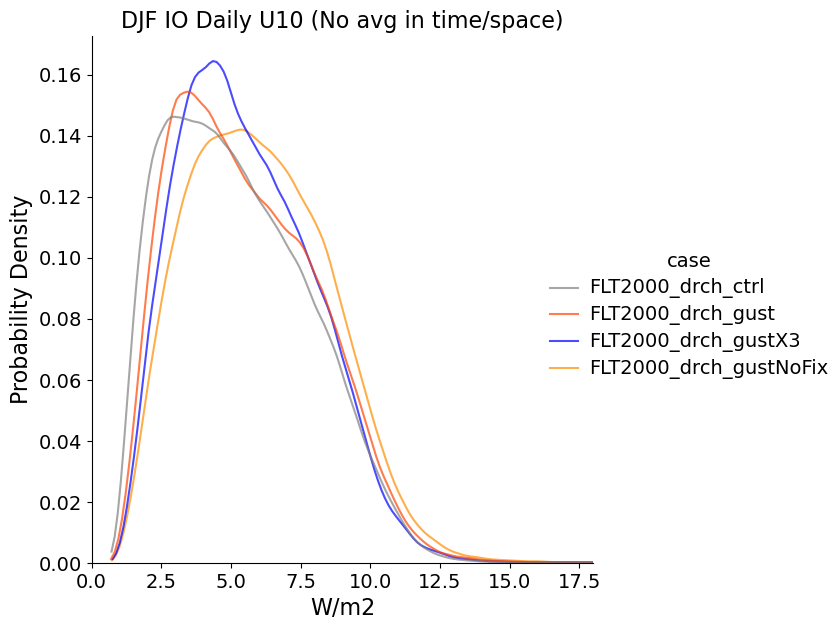

In [49]:
numEl = nTimes*nLat*nLon 
numEl_era5 = nLat*nLon 

varName = 'U10'
obsVar = 'U10'

flat_ctrlDJF  = np.squeeze( (ocnFrac_withTime*h1_fix_DJF_IO[varName].isel(case=0).values).reshape(numEl,1) )
flat_fixDJF   = np.squeeze( (ocnFrac_withTime*h1_fix_DJF_IO[varName].isel(case=1).values).reshape(numEl,1) )
flat_3fixDJF  = np.squeeze( (ocnFrac_withTime*h1_fix_DJF_IO[varName].isel(case=2).values).reshape(numEl,1) )
flat_noFixDJF = np.squeeze( (ocnFrac_withTime*h1_NoFix_DJF_IO[varName].isel(case=1).values).reshape(numEl,1) )

flat_era5DJF  = np.squeeze( (fillOcnFrac_h0_mean_IO*era5_DJF_IO[obsVar].values).reshape(numEl_era5,1) )


dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         # pd.DataFrame.from_dict({varName: flat_era5DJF, 'case': 'ERA5'}),
         pd.DataFrame.from_dict({varName: flat_ctrlDJF, 'case': str(h1_fix_DJF_IO.isel(case=0).case.values)}),
         pd.DataFrame.from_dict({varName: flat_fixDJF, 'case': str(h1_fix_DJF_IO.isel(case=1).case.values)}),
         pd.DataFrame.from_dict({varName: flat_3fixDJF, 'case': str(h1_fix_DJF_IO.isel(case=2).case.values)}),
         pd.DataFrame.from_dict({varName: flat_noFixDJF, 'case': str(h1_NoFix_DJF_IO.isel(case=1).case.values)}),
         ])

# Make plot 
g = sns.displot(dfReal, x=varName, hue='case', kind='kde', height=6, cut=0, 
                log_scale=False, common_norm = False, alpha=0.7,
                 # palette=['black','gray','orangered','blue','darkorange'])
                 palette=['gray','orangered','blue','darkorange'])

g.ax.set_xlabel(unitsString,fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
g.ax.set_title('DJF IO Daily ' +varName+' (No avg in time/space)',fontsize=16)
plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=14)

g.ax.set_xlim([0,18])


(0.0, 300.0)

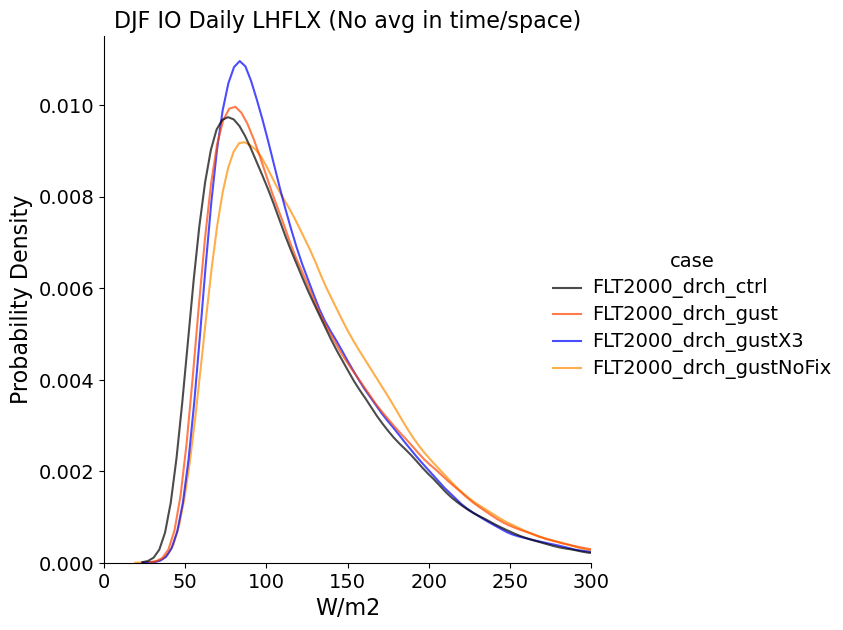

In [51]:
numEl = nTimes*nLat*nLon 

varName = 'LHFLX'

flat_ctrlDJF  = np.squeeze( (fillOcnFrac_h0_mean_IO*h1_fix_DJF_IO[varName].isel(case=0).values).reshape(numEl,1) )
flat_fixDJF   = np.squeeze( (fillOcnFrac_h0_mean_IO*h1_fix_DJF_IO[varName].isel(case=1).values).reshape(numEl,1) )
flat_3fixDJF  = np.squeeze( (fillOcnFrac_h0_mean_IO*h1_fix_DJF_IO[varName].isel(case=2).values).reshape(numEl,1) )
flat_noFixDJF = np.squeeze( (fillOcnFrac_h0_mean_IO*h1_NoFix_DJF_IO[varName].isel(case=1).values).reshape(numEl,1) )


dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({varName: flat_ctrlDJF, 'case': str(h1_fix_DJF_IO.isel(case=0).case.values)}),
         pd.DataFrame.from_dict({varName: flat_fixDJF, 'case': str(h1_fix_DJF_IO.isel(case=1).case.values)}),
         pd.DataFrame.from_dict({varName: flat_3fixDJF, 'case': str(h1_fix_DJF_IO.isel(case=2).case.values)}),
         pd.DataFrame.from_dict({varName: flat_noFixDJF, 'case': str(h1_NoFix_DJF_IO.isel(case=1).case.values)}),
         ])

# Make plot 
g = sns.displot(dfReal, x=varName, hue='case', kind='kde', height=6, cut=0, 
                log_scale=False, common_norm = False, alpha=0.7,
                 palette=['black','orangered','blue','darkorange'])

g.ax.set_xlabel(unitsString,fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
g.ax.set_title('DJF IO Daily ' +varName+' (No avg in time/space)',fontsize=16)
plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=14)

g.ax.set_xlim([0,300])


### Aside: What's happening in lab sea during this time?

In [54]:
def pltComparison_AnnMean_LabSea(varSel,dLims):    
    fig,axs = plt.subplots(1,3,figsize=(14,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    axs     = axs.ravel()
    
    plt.gcf().text(0.42, 0.85, 'Annual Mean '+varSel, fontsize=14)
    
    axs[0].set_title('Derecho (GUST_fix-CTRL)')
    axs[0].coastlines()
    axs[0].set_extent([270,349,40,90], crs=ccrs.PlateCarree())
    cplt = axs[0].contourf(diff_drch_h0.lon.values, diff_drch_h0.lat.values, diff_drch_h0[varSel].mean(dim='time').values, 
                    dLims, cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree())
    # # Add colorbar
    # ax_position = axs[0].get_position()
    # cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
    # cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')

    ### Plot x3 case 
    axs[1].set_title('Derecho (3*GUST_fix-CTRL)')
    axs[1].coastlines()
    axs[1].set_extent([270,349,40,90], crs=ccrs.PlateCarree())
    cplt = axs[1].contourf(diff_x3_drch_h0.lon.values, diff_x3_drch_h0.lat.values, diff_x3_drch_h0[varSel].mean(dim='time').values, 
                    dLims, cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree())
    # Add colorbar
    ax_position = axs[1].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.04, ax_position.width+0.2, 0.025])
    cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
    

    ### Plot noFix case
    axs[2].set_title('Derecho (GUST_noFix-CTRL)')
    axs[2].coastlines()
    axs[2].set_extent([270,349,40,90], crs=ccrs.PlateCarree())
    cplt = axs[2].contourf(diff_drchNoFix_h0.lon.values, diff_drchNoFix_h0.lat.values, diff_drchNoFix_h0[varSel].mean(dim='time').values, 
                    dLims, cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree())
    # # Add colorbar
    # ax_position = axs[1].get_position()
    # cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
    # cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
    # cbar.set_label('m/s',fontsize=11)
    
    return axs


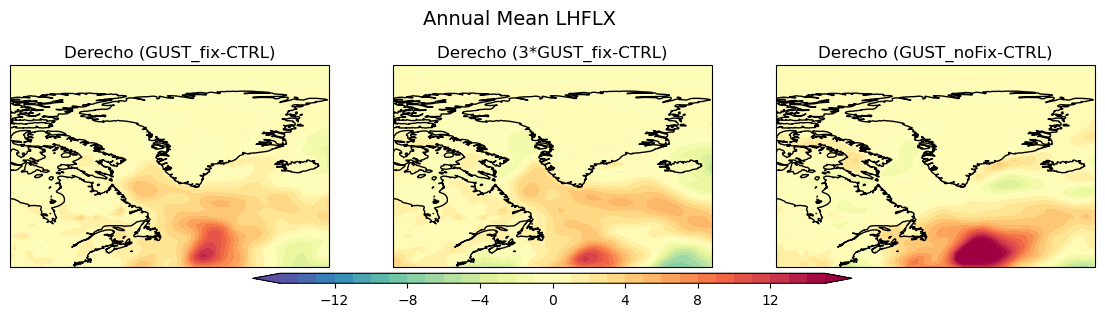

In [58]:
varSel = 'LHFLX'
diffMax = 15
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_AnnMean_LabSea(varSel,dLims)


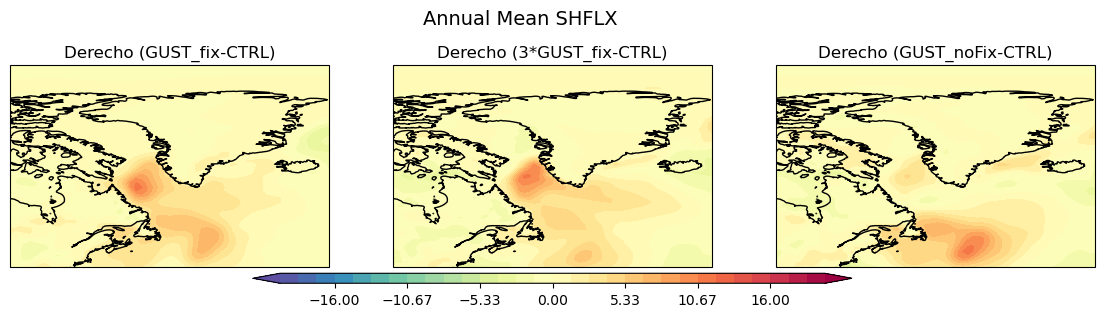

In [57]:
varSel = 'SHFLX'
diffMax = 20
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_AnnMean_LabSea(varSel,dLims)


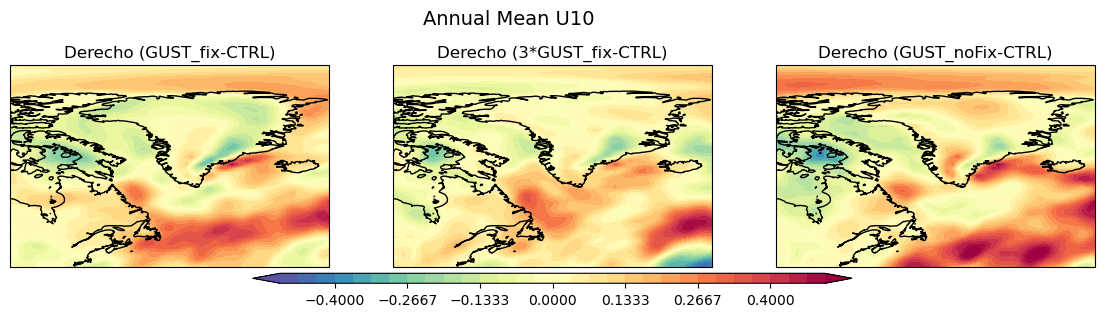

In [67]:
varSel = 'U10'
diffMax = 0.5
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_AnnMean_LabSea(varSel,dLims)


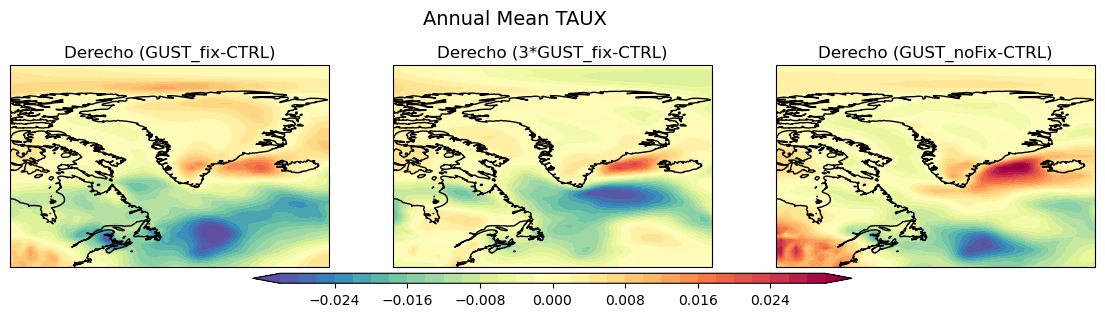

In [72]:
varSel = 'TAUX'
diffMax = 3e-2 
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_AnnMean_LabSea(varSel,dLims)


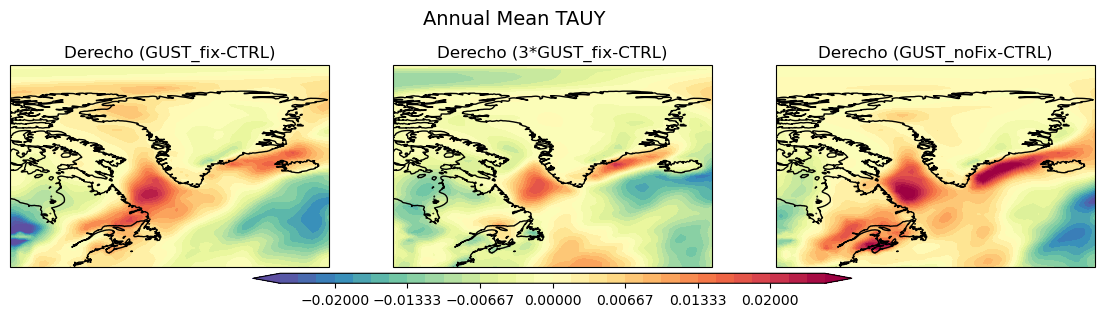

In [71]:
varSel = 'TAUY'
diffMax = 2.5e-2  
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

axs = pltComparison_AnnMean_LabSea(varSel,dLims)


## Previous attempts to compare include difference in machines

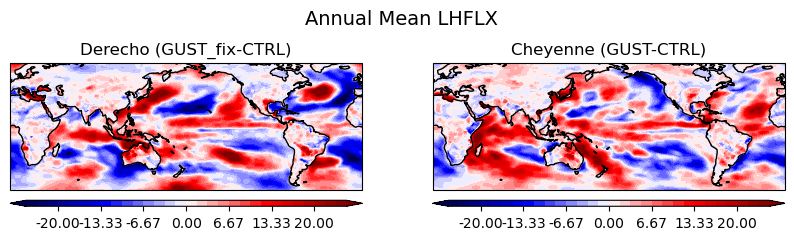

In [34]:
# varSel = 'LHFLX'
# diffMax = 25
# diffStep = (diffMax*2)/30
# dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

# fig,axs = plt.subplots(1,2,figsize=(10,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
# axs     = axs.ravel()

# plt.gcf().text(0.42, 0.75, 'Annual Mean '+varSel, fontsize=14)


# axs[0].set_title('Derecho (GUST_fix-CTRL)')
# axs[0].coastlines()
# axs[0].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
# cplt = axs[0].contourf(diff_drch_h0.lon.values, diff_drch_h0.lat.values, diff_drch_h0[varSel].mean(dim='time').values, 
#                 dLims, cmap='seismic',extend='both',transform=ccrs.PlateCarree())
# # Add colorbar
# ax_position = axs[0].get_position()
# cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
# cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
# # cbar.set_label('m/s',fontsize=11)


# axs[1].set_title('Cheyenne (GUST-CTRL)')
# axs[1].coastlines()
# axs[1].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
# cplt = axs[1].contourf(diff_chyn_h0.lon.values, diff_chyn_h0.lat.values, diff_chyn_h0[varSel].mean(dim='time').values, 
#                 dLims, cmap='seismic',extend='both',transform=ccrs.PlateCarree())
# # Add colorbar
# ax_position = axs[1].get_position()
# cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
# cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
# # cbar.set_label('m/s',fontsize=11)




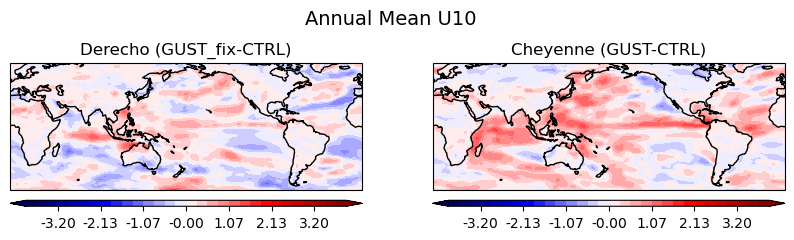

In [37]:
varSel = 'U10'
diffMax = 4
diffStep = (diffMax*2)/30
dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)

fig,axs = plt.subplots(1,2,figsize=(10,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

plt.gcf().text(0.42, 0.75, 'Annual Mean '+varSel, fontsize=14)


axs[0].set_title('Derecho (GUST_fix-CTRL)')
axs[0].coastlines()
axs[0].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
cplt = axs[0].contourf(diff_drch_h0.lon.values, diff_drch_h0.lat.values, diff_drch_h0[varSel].mean(dim='time').values, 
                dLims, cmap='seismic',extend='both',transform=ccrs.PlateCarree())
# Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
# cbar.set_label('m/s',fontsize=11)


axs[1].set_title('Cheyenne (GUST-CTRL)')
axs[1].coastlines()
axs[1].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
cplt = axs[1].contourf(diff_chyn_h0.lon.values, diff_chyn_h0.lat.values, diff_chyn_h0[varSel].mean(dim='time').values, 
                dLims, cmap='seismic',extend='both',transform=ccrs.PlateCarree())
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
# cbar.set_label('m/s',fontsize=11)




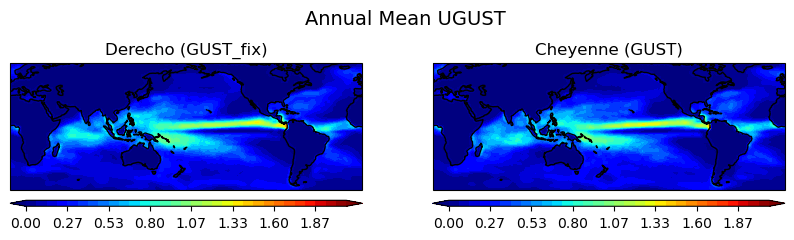

In [36]:
varSel = 'UGUST'
diffMax = 2
diffStep = (diffMax-0)/30
# dLims = np.arange(-diffMax, diffMax+diffStep, diffStep)
dLims = np.arange(0, diffMax+diffStep, diffStep)

fig,axs = plt.subplots(1,2,figsize=(10,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

plt.gcf().text(0.42, 0.75, 'Annual Mean '+varSel, fontsize=14)


axs[0].set_title('Derecho (GUST_fix)')
axs[0].coastlines()
axs[0].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
cplt = axs[0].contourf(diff_drch_h0.lon.values, diff_drch_h0.lat.values, diff_drch_h0[varSel].mean(dim='time').values, 
                dLims, cmap='jet',extend='both',transform=ccrs.PlateCarree())
# Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
# cbar.set_label('m/s',fontsize=11)


axs[1].set_title('Cheyenne (GUST)')
axs[1].coastlines()
axs[1].set_extent([0,359,-60,70], crs=ccrs.PlateCarree())
cplt = axs[1].contourf(diff_chyn_h0.lon.values, diff_chyn_h0.lat.values, diff_chyn_h0[varSel].mean(dim='time').values, 
                dLims, cmap='jet',extend='both',transform=ccrs.PlateCarree())
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
# cbar.set_label('m/s',fontsize=11)




## Attempt 1: Match ctrl across Cheyenne and Derecho 
Complicated by different output times... not *entirely* sure how to match up

In [33]:
testDir     = ['/glade/campaign/cgd/tss/people/mdfowler/GustProject/', 
               '/glade/derecho/scratch/mdfowler/archive/']

case_IDs  = [
               'FLT2000_chyn',
               'FLT2000_drch',    
              ]

caseNames = [
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsOFF.003',
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsOFF_DerchoTest.006',
]

for iCase in range(len(case_IDs)):
    print('*** Starting on case %s ***' % (case_IDs[iCase]))

    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(testDir[iCase]+caseNames[iCase]+'/atm/hist/*cam.h0*.0001-*'))
    listFiles_h1 = np.sort(glob.glob(testDir[iCase]+caseNames[iCase]+'/atm/hist/*cam.h1*.0001-*'))
    
    ## Now read in those files
    if iCase==0:
        case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0_chyn, concat_dim='time', 
                                    combine='nested', decode_times=False, 
                                    data_vars='minimal', parallel=True)
        print('h0 files loaded')
    else:
        case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                                    combine='nested', decode_times=False, 
                                    data_vars='minimal', parallel=True)
        print('h0 files loaded')
    
    case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal', parallel=True)
    print('h1 files loaded')
        
    ## Add case ID (short name) to the DS
    case_h0      = case_h0.squeeze().assign_coords({"case":  case_IDs[iCase]})
    case_h1      = case_h1.squeeze().assign_coords({"case":  case_IDs[iCase]})
    
    ## Return all the cases in a single dataset
    if iCase==0:
        h0_chyn = case_h0
        h1_chyn = case_h1 
    elif iCase==1: 
        h0_drch = case_h0
        h1_drch = case_h1
    

*** Starting on case FLT2000_chyn ***


ValueError: Cannot convert date 0001-09-16 00:00:00 to a date in the standard calendar.  Reason: Cannot cast 0001-09-16 00:00:00 to unit='ns' without overflow..

In [16]:
varSel = 'LHFLX'

diffVar = h0_drch[varSel].values - h0_chyn[varSel].values


In [31]:
print(h0_chyn.time[0])
print(h0_drch.time[0])

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1, 1, 16, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 0001-01-16 12:00:00
    case     <U12 'FLT2000_chyn'
Attributes:
    long_name:  time
    bounds:     time_bnds
<xarray.DataArray 'time' ()>
array(15.5)
Coordinates:
    time     float64 15.5
    case     <U12 'FLT2000_drch'
Attributes:
    long_name:  time
    units:      days since 0001-01-01 00:00:00
    calendar:   noleap
    bounds:     time_bounds


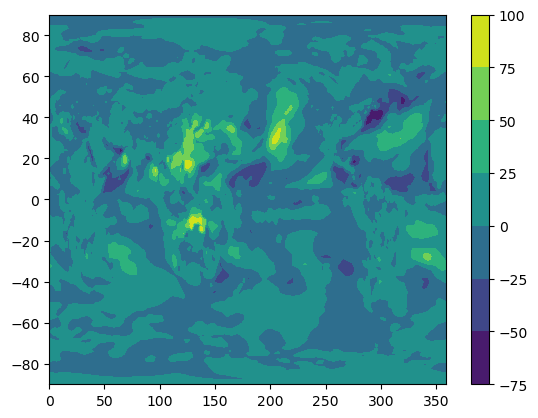

In [28]:
plt.contourf(h0_chyn.lon.values, h0_chyn.lat.values, diffVar[0,:,:])
plt.colorbar()